# Workload-Variant-Autoscaler (WVA) Performance Analysis

This notebook analyzes WVA controller logs to visualize autoscaling behavior, warmup gaps, and SLO compliance.

**Workflow:**
1. Extract metrics from WVA controller logs using the bash script
2. Load and process the CSV data
3. Detect scaling phases and warmup gaps
4. Visualize performance metrics and scaling behavior
5. Perform statistical analysis

## 1. Setup and Configuration

In [83]:
#!/usr/bin/env python3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle
from matplotlib.ticker import MultipleLocator
import subprocess
from datetime import datetime
import os

# Plotting style
plt.style.use('seaborn-v0_8')
%matplotlib inline

# X-axis granularity configuration (in minutes)
X_MAJOR_TICK_INTERVAL = 1.0  # Major tick every 1 minute
X_MINOR_TICK_INTERVAL = 0.5  # Minor tick every 0.5 minutes (30 seconds)

# Configuration
LOG_DIR = f'./txt_logs'
LOG_NAME = 'ttft_queuescorer_SLO_10_10_24'  # Change this to your log name
LOG_FILE = f'{LOG_DIR}/{LOG_NAME}.txt'  # Change this to your log file
EXTRACT_SCRIPT = './extract_metrics.sh'

# Generate unique experiment directory based on timestamp
EXPERIMENT_NAME = datetime.now().strftime('%Y%m%d_%H%M%S')
EXPERIMENT_DIR = f'experiments/{EXPERIMENT_NAME}_{LOG_NAME}'
OUTPUT_CSV = f'{EXPERIMENT_DIR}/extracted_metrics.csv'

# Create experiment directory structure
os.makedirs(f'{EXPERIMENT_DIR}/plots', exist_ok=True)
os.makedirs(f'{EXPERIMENT_DIR}/data', exist_ok=True)
os.makedirs(f'{EXPERIMENT_DIR}/analysis', exist_ok=True)

print(f"✅ Configuration loaded")
print(f"   Experiment: {EXPERIMENT_NAME}")
print(f"   Experiment directory: {EXPERIMENT_DIR}")
print(f"   Log file: {LOG_FILE}")
print(f"   Extract script: {EXTRACT_SCRIPT}")
print(f"   Output CSV: {OUTPUT_CSV}")

✅ Configuration loaded
   Experiment: 20251024_233822
   Experiment directory: experiments/20251024_233822_ttft_queuescorer_SLO_10_10_24
   Log file: ./txt_logs/ttft_queuescorer_SLO_10_10_24.txt
   Extract script: ./extract_metrics.sh
   Output CSV: experiments/20251024_233822_ttft_queuescorer_SLO_10_10_24/extracted_metrics.csv


**📊 X-Axis Granularity Settings:**
- **Major ticks** (bold lines with labels): Every **0.5 minutes** (30 seconds)
- **Minor ticks** (light grid lines): Every **0.1 minutes** (6 seconds)

💡 *To adjust granularity, change `X_MAJOR_TICK_INTERVAL` and `X_MINOR_TICK_INTERVAL` above:*
- For **coarser** view: Use 1.0 (major) and 0.5 (minor) for 1-minute intervals
- For **finer** view: Use 0.25 (major) and 0.05 (minor) for 15-second intervals
- For **very fine** view: Use 0.1 (major) and 0.02 (minor) for 6-second intervals

## 2. Extract Metrics from Logs

Run the bash script to parse the WVA controller logs and extract optimization metrics.

In [84]:
# Make the script executable
!chmod +x {EXTRACT_SCRIPT}

# Run the extraction script
print(f"📊 Extracting metrics from {LOG_FILE}...")
result = subprocess.run(
    [EXTRACT_SCRIPT, LOG_FILE],
    capture_output=True,
    text=True
)

# Save to CSV
with open(OUTPUT_CSV, 'w') as f:
    f.write(result.stdout)

print(f"✅ Metrics extracted to {OUTPUT_CSV}")
print(f"   Lines extracted: {len(result.stdout.splitlines())}")

# Preview the first few lines
print("\n📋 Preview of extracted data:")
!head -5 {OUTPUT_CSV}

📊 Extracting metrics from ./txt_logs/ttft_queuescorer_SLO_10_10_24.txt...
✅ Metrics extracted to experiments/20251024_233822_ttft_queuescorer_SLO_10_10_24/extracted_metrics.csv
   Lines extracted: 85

📋 Preview of extracted data:
timestamp,itlAverage,ttftAverage,rate,inTk,outTk,numRep,itl,ttft,slo_itl,slo_ttft
2025-10-24T13:41:38.691Z,0,0,0,0,0,1,7,5.2999997,10,1000
2025-10-24T13:41:38.705Z,0,0,0,0,0,1,7,5.2999997,10,1000
2025-10-24T13:42:38.711Z,0,0,0,0,0,1,7,5.2999997,10,1000
2025-10-24T13:42:38.726Z,0,0,0,0,0,1,7,5.2999997,10,1000
timestamp,itlAverage,ttftAverage,rate,inTk,outTk,numRep,itl,ttft,slo_itl,slo_ttft
2025-10-24T13:41:38.691Z,0,0,0,0,0,1,7,5.2999997,10,1000
2025-10-24T13:41:38.705Z,0,0,0,0,0,1,7,5.2999997,10,1000
2025-10-24T13:42:38.711Z,0,0,0,0,0,1,7,5.2999997,10,1000
2025-10-24T13:42:38.726Z,0,0,0,0,0,1,7,5.2999997,10,1000


## 3. Load and Process Data

### 3.1 Diagnostics (Run if you get errors)

In [85]:
print("🔍 Diagnosing extraction issue...\n")

# 1. Check log file
print(f"1. Log file check:")
log_path = LOG_FILE
BASH_SCRIPT = EXTRACT_SCRIPT
if os.path.exists(log_path):
    size = os.path.getsize(log_path)
    print(f"   ✓ File exists: {log_path}")
    print(f"   ✓ Size: {size:,} bytes")
    
    # Sample first few lines
    print(f"\n   First 5 lines of log file:")
    with open(log_path, 'r') as f:
        for i, line in enumerate(f):
            if i >= 5:
                break
            print(f"   {i+1}: {line[:100]}...")
else:
    print(f"   ✗ File not found: {log_path}")

# 2. Check CSV output
print(f"\n2. CSV output check:")
if os.path.exists(OUTPUT_CSV):
    size = os.path.getsize(OUTPUT_CSV)
    print(f"   ✓ File exists: {OUTPUT_CSV}")
    print(f"   ✓ Size: {size:,} bytes")
    
    if size > 0:
        # Read CSV and show structure
        df_test = pd.read_csv(OUTPUT_CSV)
        print(f"   ✓ Rows: {len(df_test)}")
        print(f"   ✓ Columns: {list(df_test.columns)}")
        
        if len(df_test) > 0:
            print(f"\n   First row:")
            print(df_test.head(1).to_string())
        else:
            print(f"   ✗ CSV has no data rows (only headers)")
    else:
        print(f"   ✗ CSV is empty (0 bytes)")
else:
    print(f"   ✗ File not found: {OUTPUT_CSV}")

# 3. Check for JSON patterns in log file
print(f"\n3. Log format check:")
if os.path.exists(log_path):
    with open(log_path, 'r') as f:
        content = f.read()
        
    # Look for expected patterns
    has_optimization = 'optimizationMetrics' in content
    has_itl = 'itlAverage' in content or '"itl"' in content
    has_ttft = 'ttftAverage' in content or '"ttft"' in content
    
    print(f"   optimizationMetrics found: {'✓' if has_optimization else '✗'}")
    print(f"   ITL metrics found: {'✓' if has_itl else '✗'}")
    print(f"   TTFT metrics found: {'✓' if has_ttft else '✗'}")
    
    if not (has_optimization or has_itl):
        print(f"\n   ⚠️  Log file doesn't appear to contain expected metrics.")
        print(f"   Expected format: JSON with 'optimizationMetrics' field")
        print(f"\n   Sample expected format:")
        print(f'   {{"optimizationMetrics":{{"itlAverage":12.5,"ttftAverage":850,"rate":45.2,...}}}}')

print("\n" + "="*70)
print("If you see issues above, check:")
print("  1. Is LOG_FILE pointing to the correct WVA controller log file?")
print("  2. Does the log contain optimizationMetrics JSON entries?")
print("  3. Try running the extraction manually:")
print(f"     {BASH_SCRIPT} {LOG_FILE}")
print("="*70)

🔍 Diagnosing extraction issue...

1. Log file check:
   ✓ File exists: ./txt_logs/ttft_queuescorer_SLO_10_10_24.txt
   ✓ Size: 471,907 bytes

   First 5 lines of log file:
   1: {"level":"INFO","ts":"2025-10-24T13:41:21.913Z","msg":"Zap logger initialized"}
...
   2: {"level":"INFO","ts":"2025-10-24T13:41:21.975Z","msg":"Creating metrics emitter instance"}
...
   3: {"level":"INFO","ts":"2025-10-24T13:41:21.975Z","msg":"Metrics emitter created successfully"}
...
   4: {"level":"INFO","ts":"2025-10-24T13:41:21.975Z","msg":"Using Prometheus configuration from environme...
   5: {"level":"WARN","ts":"2025-10-24T13:41:21.975Z","msg":"TLS certificate verification is disabled - th...

2. CSV output check:
   ✓ File exists: experiments/20251024_233822_ttft_queuescorer_SLO_10_10_24/extracted_metrics.csv
   ✓ Size: 6,329 bytes
   ✓ Rows: 84
   ✓ Columns: ['timestamp', 'itlAverage', 'ttftAverage', 'rate', 'inTk', 'outTk', 'numRep', 'itl', 'ttft', 'slo_itl', 'slo_ttft']

   First row:
           

In [86]:
# Load the CSV data
df = pd.read_csv(OUTPUT_CSV)

# Check if data was extracted
if len(df) == 0:
    print("❌ ERROR: No data was extracted from the log file!")
    print("\nPossible issues:")
    print("1. Log file format doesn't match the extraction script")
    print("2. Log file doesn't contain optimization data")
    print("3. Log file path is incorrect")
    print(f"\nLog file: {LOG_FILE}")
    print(f"CSV file: {OUTPUT_CSV}")
    print("\nPlease check:")
    print("- Does the log file exist and have content?")
    print("- Does it contain lines with 'System data prepared for optimization'?")
    print("- Is the extraction script working correctly?")
    print("\nRun this to check the log file:")
    print(f"  !grep -i 'optimization' {LOG_FILE} | head -5")
    raise ValueError("No data extracted - please check log file and extraction script")

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Calculate time in minutes from start
df['time_minutes'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds() / 60

# Display basic statistics
print("📊 Data Summary:")
print(f"   Duration: {df['time_minutes'].max():.1f} minutes")
print(f"   Data points: {len(df)}")
print(f"   Replica range: {df['numRep'].min():.0f} → {df['numRep'].max():.0f}")
print(f"   Load range: {df['rate'].min():.1f} → {df['rate'].max():.1f} rpm")
print(f"   SLO ITL: {df['slo_itl'].iloc[0]:.0f} ms")
print(f"   SLO TTFT: {df['slo_ttft'].iloc[0]:.0f} ms")

# Display first few rows
print("\n📋 Data preview:")
df.head(10)

📊 Data Summary:
   Duration: 41.0 minutes
   Data points: 84
   Replica range: 1 → 5
   Load range: 0.0 → 3376.8 rpm
   SLO ITL: 10 ms
   SLO TTFT: 1000 ms

📋 Data preview:


,timestamp,itlAverage,ttftAverage,rate,inTk,outTk,numRep,itl,ttft,slo_itl,slo_ttft,time_minutes
0,2025-10-24 13:41:38.691000+00:00,0.0,0.0,0.0,0,0,1,7.0,5.3,10,1000,0.000000
1,2025-10-24 13:41:38.705000+00:00,0.0,0.0,0.0,0,0,1,7.0,5.3,10,1000,0.000233
2,2025-10-24 13:42:38.711000+00:00,0.0,0.0,0.0,0,0,1,7.0,5.3,10,1000,1.000333
3,2025-10-24 13:42:38.726000+00:00,0.0,0.0,0.0,0,0,1,7.0,5.3,10,1000,1.000583
4,2025-10-24 13:43:38.734000+00:00,0.0,0.0,0.0,0,0,1,7.0,5.3,10,1000,2.000717
5,2025-10-24 13:43:38.750000+00:00,0.0,0.0,0.0,0,0,1,7.0,5.3,10,1000,2.000983
6,2025-10-24 13:44:38.757000+00:00,0.0,0.0,0.0,0,0,1,7.0,5.3,10,1000,3.001100
7,2025-10-24 13:44:38.773000+00:00,0.0,0.0,0.0,0,0,1,7.0,5.3,10,1000,3.001367
8,2025-10-24 13:45:38.780000+00:00,0.0,0.0,0.0,0,0,1,7.0,5.3,10,1000,4.001483
9,2025-10-24 13:45:38.796000+00:00,0.0,0.0,0.0,0,0,1,7.0,5.3,10,1000,4.001750


## 4. Detect Scaling Events and Warmup Gaps

In [87]:
def detect_scaling_events(df, slo_threshold=None):
    """
    Detect scaling events and warmup gaps where actual TPOT exceeds SLO.
    """
    if slo_threshold is None:
        slo_threshold = df['slo_itl'].iloc[0]
    
    scaling_events = []
    warmup_gaps = []
    
    # Detect replica changes
    for i in range(1, len(df)):
        if df['numRep'].iloc[i] != df['numRep'].iloc[i-1]:
            scaling_events.append({
                'time': df['time_minutes'].iloc[i],
                'from_replicas': df['numRep'].iloc[i-1],
                'to_replicas': df['numRep'].iloc[i],
                'load': df['rate'].iloc[i]
            })
    
    # Detect warmup gaps (TPOT > SLO)
    in_gap = False
    gap_start = None
    
    for i in range(len(df)):
        tpot = df['itlAverage'].iloc[i]
        
        if tpot > slo_threshold and not in_gap:
            # Start of warmup gap
            in_gap = True
            gap_start = i
        elif tpot <= slo_threshold and in_gap:
            # End of warmup gap
            in_gap = False
            warmup_gaps.append({
                'start_time': df['time_minutes'].iloc[gap_start],
                'end_time': df['time_minutes'].iloc[i-1],
                'duration': df['time_minutes'].iloc[i-1] - df['time_minutes'].iloc[gap_start],
                'peak_violation': df['itlAverage'].iloc[gap_start:i].max(),
                'avg_tpot': df['itlAverage'].iloc[gap_start:i].mean(),
                'avg_load': df['rate'].iloc[gap_start:i].mean()
            })
    
    return scaling_events, warmup_gaps

# Detect events
scaling_events, warmup_gaps = detect_scaling_events(df)

print("🔄 Scaling Events Detected:")
for i, event in enumerate(scaling_events, 1):
    print(f"   {i}. t={event['time']:.1f}min: {event['from_replicas']:.0f} → {event['to_replicas']:.0f} replicas (load: {event['load']:.1f} rpm)")

print("\n⚠️  Warmup Gaps Detected (TPOT > SLO):")
for i, gap in enumerate(warmup_gaps, 1):
    print(f"   {i}. t={gap['start_time']:.1f}-{gap['end_time']:.1f}min ({gap['duration']:.1f}min)")
    print(f"      Peak: {gap['peak_violation']:.2f}ms, Avg: {gap['avg_tpot']:.2f}ms, Load: {gap['avg_load']:.0f} rpm")

🔄 Scaling Events Detected:
   1. t=10.0min: 1 → 2 replicas (load: 831.9 rpm)
   2. t=16.0min: 2 → 3 replicas (load: 1712.2 rpm)
   3. t=22.0min: 3 → 5 replicas (load: 3338.1 rpm)
   4. t=28.0min: 5 → 3 replicas (load: 1675.8 rpm)
   5. t=29.0min: 3 → 2 replicas (load: 1532.9 rpm)
   6. t=30.0min: 2 → 3 replicas (load: 1660.9 rpm)
   7. t=31.0min: 3 → 2 replicas (load: 1593.0 rpm)
   8. t=32.0min: 2 → 3 replicas (load: 1612.1 rpm)
   9. t=34.0min: 3 → 2 replicas (load: 800.0 rpm)
   10. t=40.0min: 2 → 1 replicas (load: 20.5 rpm)

⚠️  Warmup Gaps Detected (TPOT > SLO):
   1. t=10.0-10.0min (0.0min)
      Peak: 10.09ms, Avg: 10.09ms, Load: 832 rpm
   2. t=22.0-24.0min (2.0min)
      Peak: 10.42ms, Avg: 10.35ms, Load: 3361 rpm


## 5. Visualization: ITL Performance with Warmup Gaps

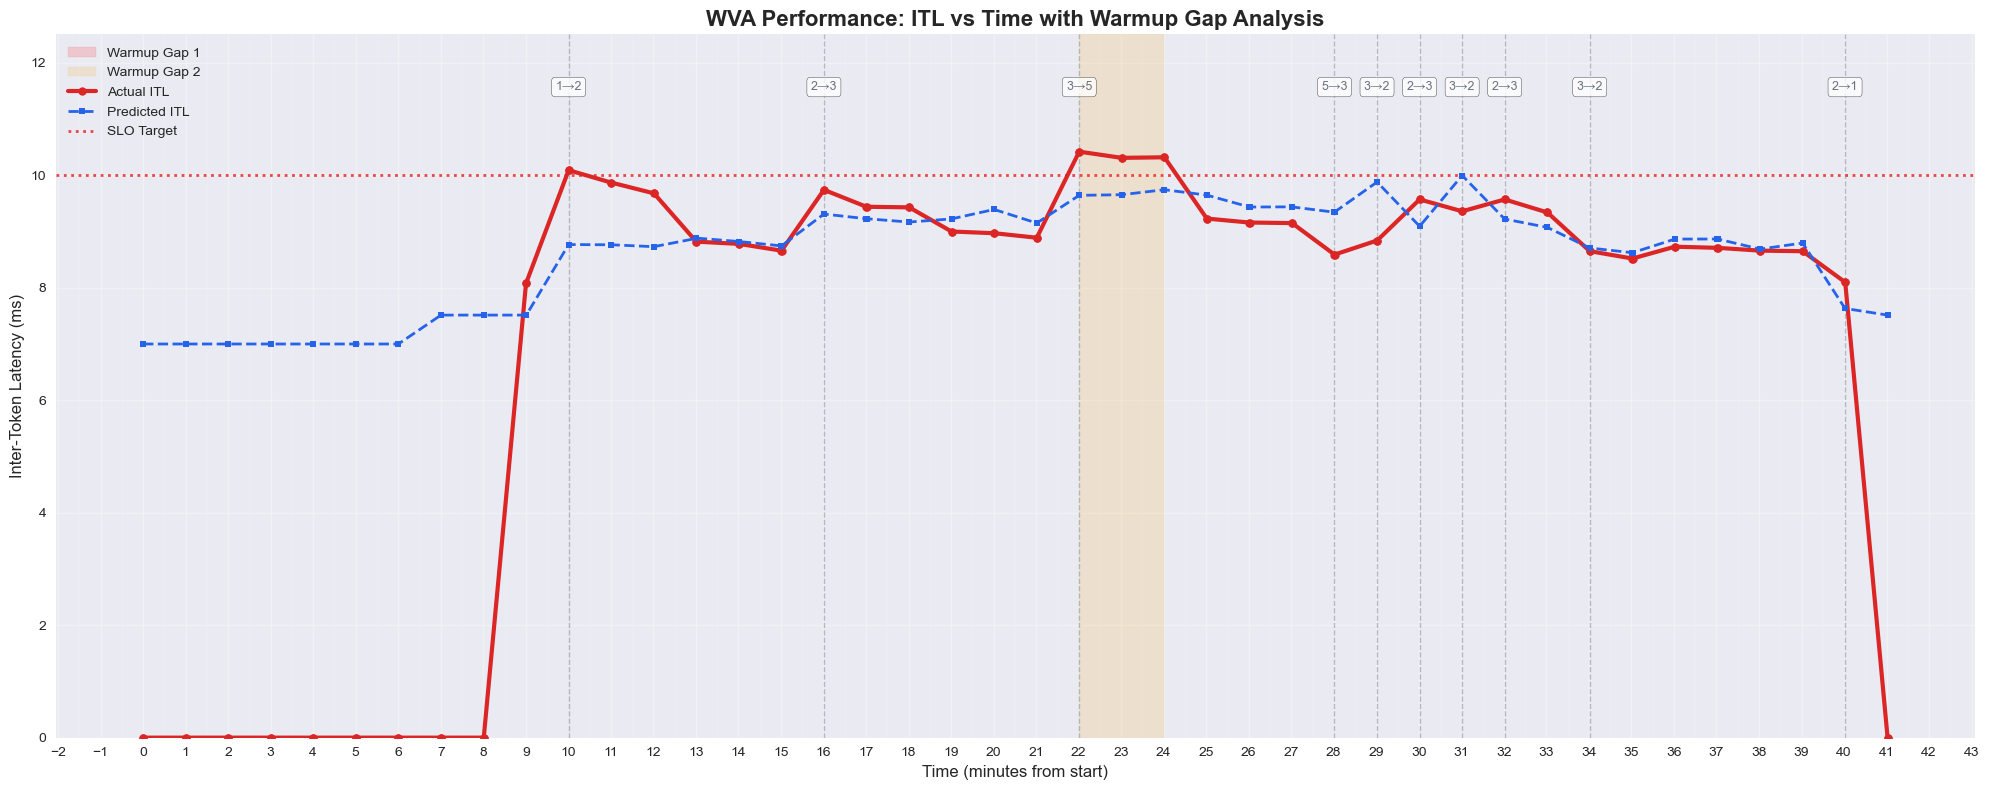

✅ Plot saved as 'experiments/20251024_233822_ttft_queuescorer_SLO_10_10_24/plots/itl_analysis.png'


In [88]:
fig, ax = plt.subplots(figsize=(20, 8))

# Highlight warmup gaps
for i, gap in enumerate(warmup_gaps):
    color = ['red', 'orange', 'yellow'][i % 3]
    rect = Rectangle(
        (gap['start_time'], 0),
        gap['end_time'] - gap['start_time'],
        df['itlAverage'].max() * 1.2,
        alpha=0.15,
        color=color,
        label=f"Warmup Gap {i+1}"
    )
    ax.add_patch(rect)

# Plot ITL metrics
ax.plot(df['time_minutes'], df['itlAverage'], 'o-', 
        linewidth=3, markersize=6, color='#dc2626', 
        label='Actual ITL', zorder=3)
ax.plot(df['time_minutes'], df['itl'], 's--', 
        linewidth=2, markersize=4, color='#2563eb', 
        label='Predicted ITL', zorder=3)
ax.axhline(y=df['slo_itl'].iloc[0], color='#ef4444', 
           linestyle=':', linewidth=2, label='SLO Target', zorder=2)

# Mark scaling events
for event in scaling_events:
    ax.axvline(x=event['time'], color='#9ca3af', 
               linestyle='--', alpha=0.7, linewidth=1, zorder=1)
    ax.text(event['time'], df['itlAverage'].max() * 1.1, 
            f"{event['from_replicas']:.0f}→{event['to_replicas']:.0f}",
            ha='center', va='bottom', fontsize=9, color='#6b7280',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

ax.set_xlabel('Time (minutes from start)', fontsize=12)
ax.set_ylabel('Inter-Token Latency (ms)', fontsize=12)
ax.set_title('WVA Performance: ITL vs Time with Warmup Gap Analysis', 
             fontweight='bold', fontsize=16)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_ylim(0, df['itlAverage'].max() * 1.2)

# Set x-axis granularity
ax.xaxis.set_major_locator(MultipleLocator(X_MAJOR_TICK_INTERVAL))
ax.xaxis.set_minor_locator(MultipleLocator(X_MINOR_TICK_INTERVAL))
ax.grid(True, which='major', alpha=0.3, linewidth=1)
ax.grid(True, which='minor', alpha=0.15, linewidth=0.5)

plt.tight_layout()
plot_path = f'{EXPERIMENT_DIR}/plots/itl_analysis.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Plot saved as '{plot_path}'")

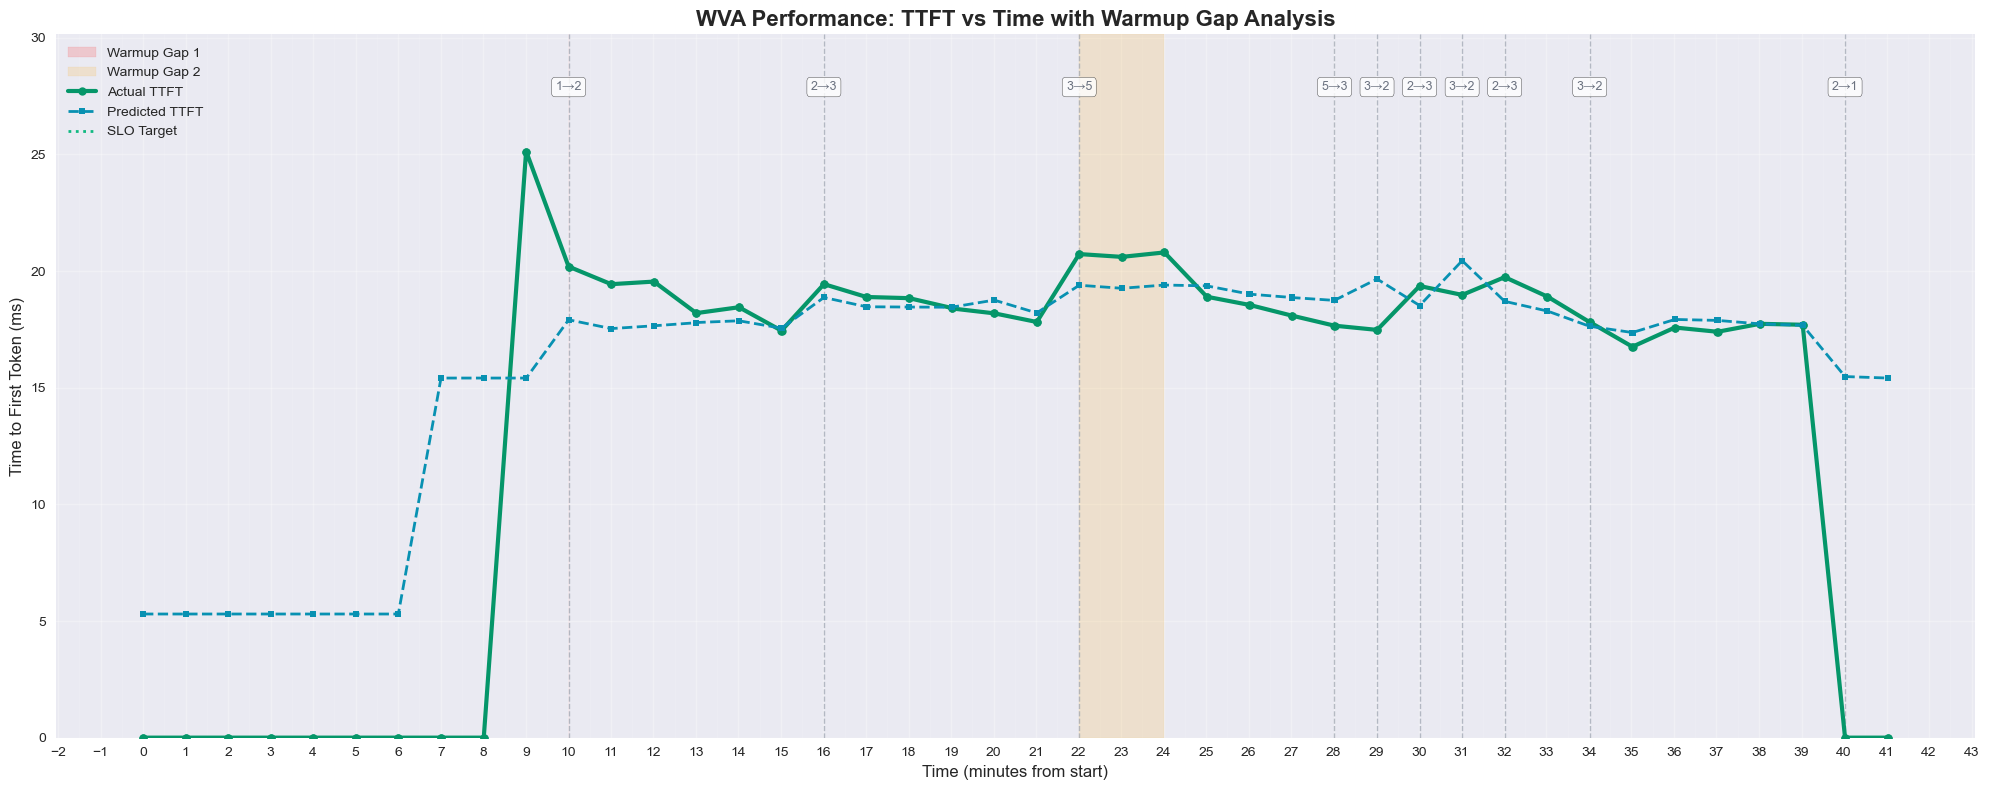

✅ Plot saved as 'experiments/20251024_233822_ttft_queuescorer_SLO_10_10_24/plots/ttft_analysis.png'


In [89]:
fig, ax = plt.subplots(figsize=(20, 8))

# Highlight warmup gaps
for i, gap in enumerate(warmup_gaps):
    color = ['red', 'orange', 'yellow'][i % 3]
    rect = Rectangle(
        (gap['start_time'], 0),
        gap['end_time'] - gap['start_time'],
        df['ttftAverage'].max() * 1.2,
        alpha=0.15,
        color=color,
        label=f"Warmup Gap {i+1}"
    )
    ax.add_patch(rect)

# Plot TTFT metrics
ax.plot(df['time_minutes'], df['ttftAverage'], 'o-', 
        linewidth=3, markersize=6, color='#059669', 
        label='Actual TTFT', zorder=3)
ax.plot(df['time_minutes'], df['ttft'], 's--', 
        linewidth=2, markersize=4, color='#0891b2', 
        label='Predicted TTFT', zorder=3)
ax.axhline(y=df['slo_ttft'].iloc[0], color='#10b981', 
           linestyle=':', linewidth=2, label='SLO Target', zorder=2)

# Mark scaling events
for event in scaling_events:
    ax.axvline(x=event['time'], color='#9ca3af', 
               linestyle='--', alpha=0.7, linewidth=1, zorder=1)
    ax.text(event['time'], df['ttftAverage'].max() * 1.1, 
            f"{event['from_replicas']:.0f}→{event['to_replicas']:.0f}",
            ha='center', va='bottom', fontsize=9, color='#6b7280',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

ax.set_xlabel('Time (minutes from start)', fontsize=12)
ax.set_ylabel('Time to First Token (ms)', fontsize=12)
ax.set_title('WVA Performance: TTFT vs Time with Warmup Gap Analysis', 
             fontweight='bold', fontsize=16)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_ylim(0, df['ttftAverage'].max() * 1.2)

# Set x-axis granularity
ax.xaxis.set_major_locator(MultipleLocator(X_MAJOR_TICK_INTERVAL))
ax.xaxis.set_minor_locator(MultipleLocator(X_MINOR_TICK_INTERVAL))
ax.grid(True, which='major', alpha=0.3, linewidth=1)
ax.grid(True, which='minor', alpha=0.15, linewidth=0.5)

plt.tight_layout()
plot_path = f'{EXPERIMENT_DIR}/plots/ttft_analysis.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Plot saved as '{plot_path}'")

## 6. Visualization: TTFT Performance with Warmup Gaps

## 7. Visualization: Load Pattern Evolution

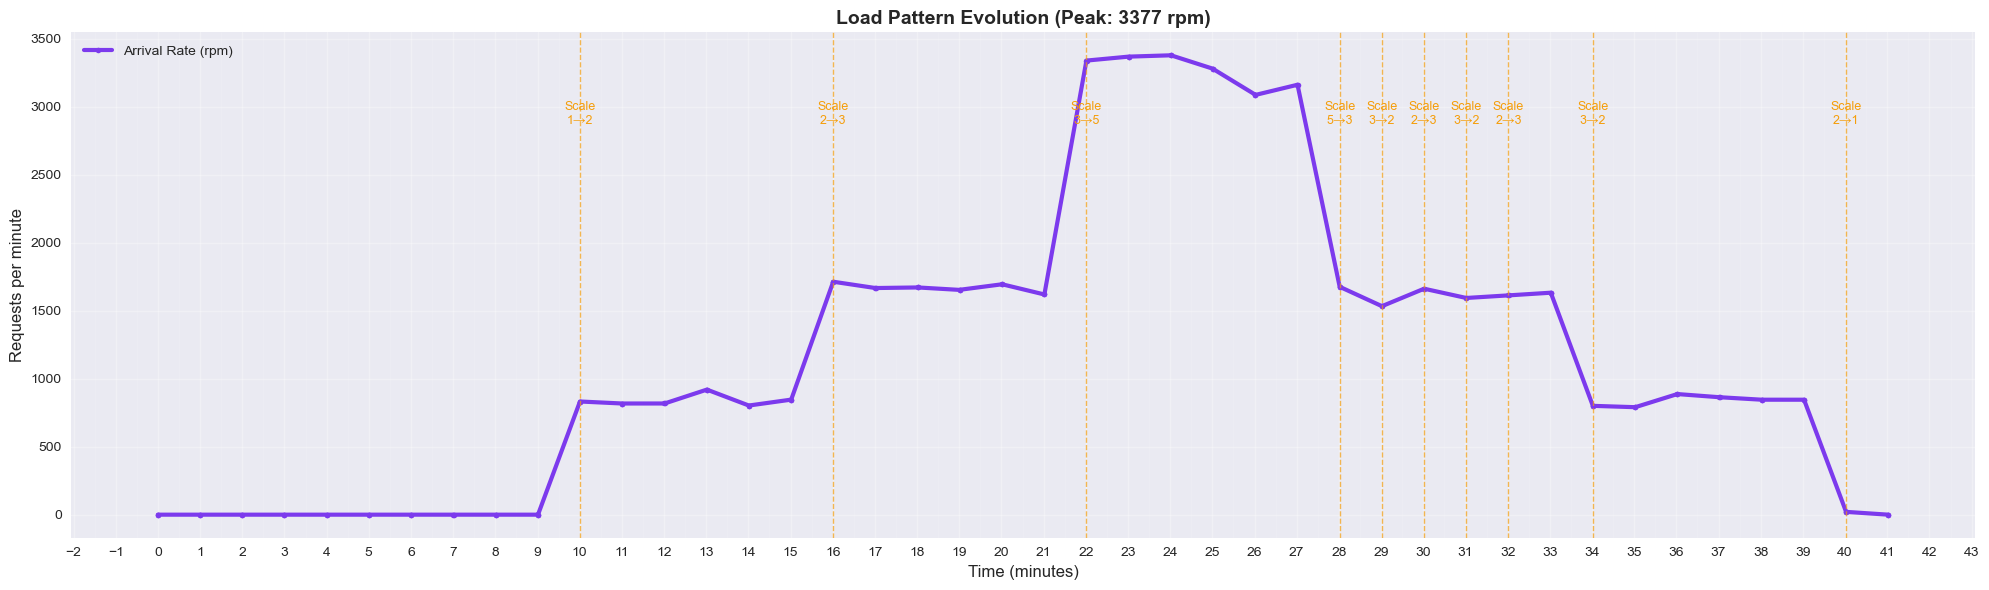

✅ Plot saved as 'experiments/20251024_233822_ttft_queuescorer_SLO_10_10_24/plots/load_pattern.png'


In [90]:
fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(df['time_minutes'], df['rate'], 'o-', 
        linewidth=3, markersize=4, color='#7c3aed', 
        label='Arrival Rate (rpm)')

# Mark scaling events
for event in scaling_events:
    ax.axvline(x=event['time'], color='#f59e0b', 
               linestyle='--', alpha=0.7, linewidth=1)
    ax.text(event['time'], df['rate'].max() * 0.9,
            f"Scale\n{event['from_replicas']:.0f}→{event['to_replicas']:.0f}",
            ha='center', va='top', fontsize=9, color='#f59e0b')

ax.set_xlabel('Time (minutes)', fontsize=12)
ax.set_ylabel('Requests per minute', fontsize=12)
ax.set_title(f"Load Pattern Evolution (Peak: {df['rate'].max():.0f} rpm)",
             fontweight='bold', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

# Set x-axis granularity
ax.xaxis.set_major_locator(MultipleLocator(X_MAJOR_TICK_INTERVAL))
ax.xaxis.set_minor_locator(MultipleLocator(X_MINOR_TICK_INTERVAL))
ax.grid(True, which='major', alpha=0.3, linewidth=1)
ax.grid(True, which='minor', alpha=0.15, linewidth=0.5)

plt.tight_layout()
plot_path = f'{EXPERIMENT_DIR}/plots/load_pattern.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Plot saved as '{plot_path}'")

## 8. Visualization: ITL vs Replica Scaling Timeline

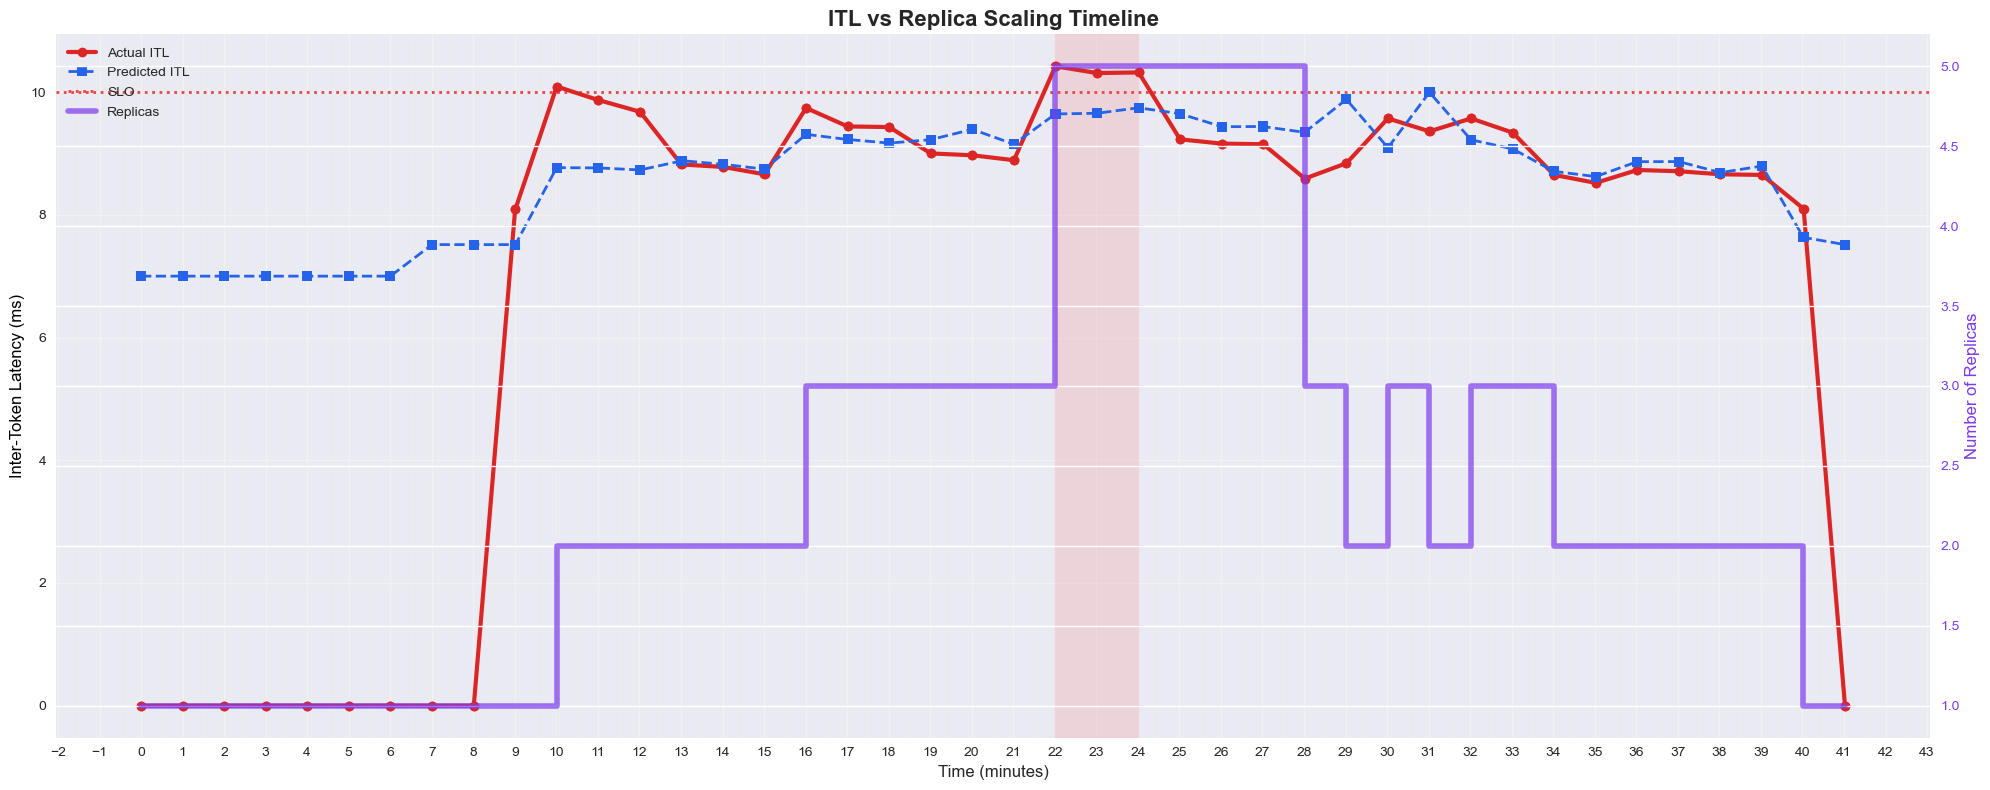

✅ Plot saved as 'experiments/20251024_233822_ttft_queuescorer_SLO_10_10_24/plots/itl_replicas_timeline.png'


In [91]:
fig, ax1 = plt.subplots(figsize=(20, 8))
ax2 = ax1.twinx()

# ITL on left axis
line1 = ax1.plot(df['time_minutes'], df['itlAverage'], 'o-', 
                 linewidth=3, color='#dc2626', label='Actual ITL', zorder=3)
line2 = ax1.plot(df['time_minutes'], df['itl'], 's--', 
                 linewidth=2, color='#2563eb', label='Predicted ITL', zorder=3)
ax1.axhline(y=df['slo_itl'].iloc[0], color='#ef4444', 
            linestyle=':', linewidth=2, label='SLO')

# Replicas on right axis
line3 = ax2.step(df['time_minutes'], df['numRep'], where='post',
                 linewidth=4, color='#7c3aed', alpha=0.7, label='Replicas')

# Highlight warmup gaps
for gap in warmup_gaps:
    ax1.axvspan(gap['start_time'], gap['end_time'], 
                alpha=0.1, color='red', zorder=1)

ax1.set_xlabel('Time (minutes)', fontsize=12)
ax1.set_ylabel('Inter-Token Latency (ms)', color='black', fontsize=12)
ax2.set_ylabel('Number of Replicas', color='#7c3aed', fontsize=12)
ax2.tick_params(axis='y', labelcolor='#7c3aed')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

ax1.set_title('ITL vs Replica Scaling Timeline', fontweight='bold', fontsize=16)
ax1.grid(True, alpha=0.3)

# Set x-axis granularity
ax1.xaxis.set_major_locator(MultipleLocator(X_MAJOR_TICK_INTERVAL))
ax1.xaxis.set_minor_locator(MultipleLocator(X_MINOR_TICK_INTERVAL))
ax1.grid(True, which='major', alpha=0.3, linewidth=1)
ax1.grid(True, which='minor', alpha=0.15, linewidth=0.5)

plt.tight_layout()
plot_path = f'{EXPERIMENT_DIR}/plots/itl_replicas_timeline.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Plot saved as '{plot_path}'")

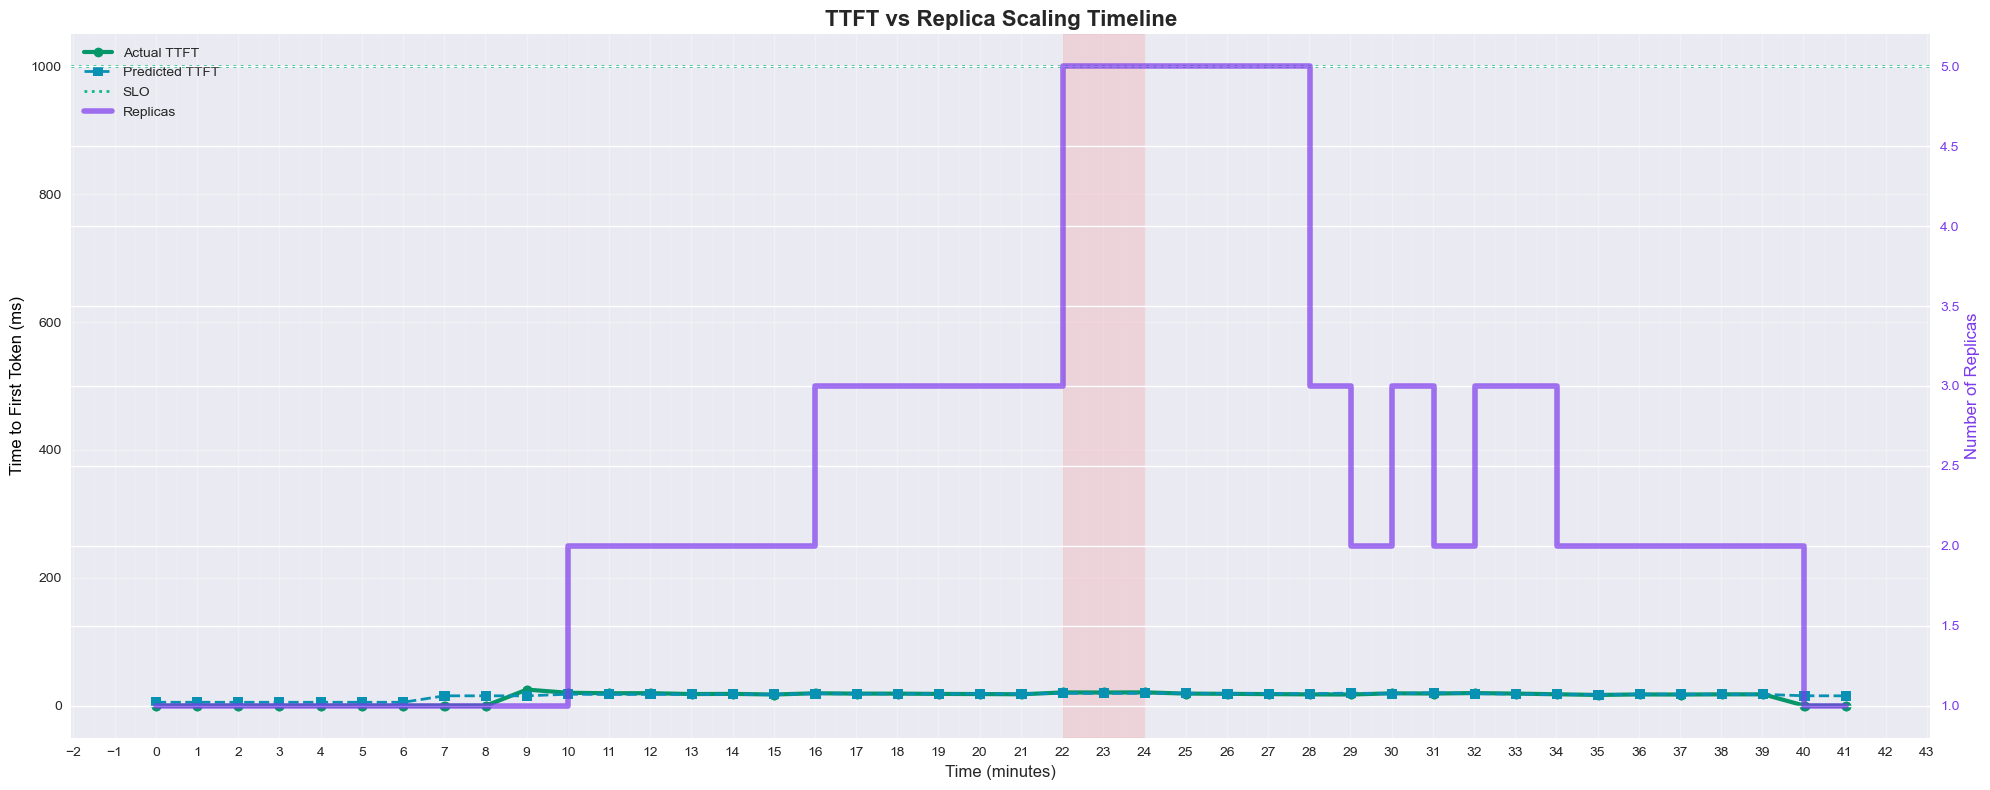

✅ Plot saved as 'experiments/20251024_233822_ttft_queuescorer_SLO_10_10_24/plots/ttft_replicas_timeline.png'


In [92]:
fig, ax1 = plt.subplots(figsize=(20, 8))
ax2 = ax1.twinx()

# TTFT on left axis
line1 = ax1.plot(df['time_minutes'], df['ttftAverage'], 'o-', 
                 linewidth=3, color='#059669', label='Actual TTFT', zorder=3)
line2 = ax1.plot(df['time_minutes'], df['ttft'], 's--', 
                 linewidth=2, color='#0891b2', label='Predicted TTFT', zorder=3)
ax1.axhline(y=df['slo_ttft'].iloc[0], color='#10b981', 
            linestyle=':', linewidth=2, label='SLO')

# Replicas on right axis
line3 = ax2.step(df['time_minutes'], df['numRep'], where='post',
                 linewidth=4, color='#7c3aed', alpha=0.7, label='Replicas')

# Highlight warmup gaps
for gap in warmup_gaps:
    ax1.axvspan(gap['start_time'], gap['end_time'], 
                alpha=0.1, color='red', zorder=1)

ax1.set_xlabel('Time (minutes)', fontsize=12)
ax1.set_ylabel('Time to First Token (ms)', color='black', fontsize=12)
ax2.set_ylabel('Number of Replicas', color='#7c3aed', fontsize=12)
ax2.tick_params(axis='y', labelcolor='#7c3aed')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

ax1.set_title('TTFT vs Replica Scaling Timeline', fontweight='bold', fontsize=16)
ax1.grid(True, alpha=0.3)

# Set x-axis granularity
ax1.xaxis.set_major_locator(MultipleLocator(X_MAJOR_TICK_INTERVAL))
ax1.xaxis.set_minor_locator(MultipleLocator(X_MINOR_TICK_INTERVAL))
ax1.grid(True, which='major', alpha=0.3, linewidth=1)
ax1.grid(True, which='minor', alpha=0.15, linewidth=0.5)

plt.tight_layout()
plot_path = f'{EXPERIMENT_DIR}/plots/ttft_replicas_timeline.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Plot saved as '{plot_path}'")

## 9. Visualization: TTFT vs Replica Scaling Timeline

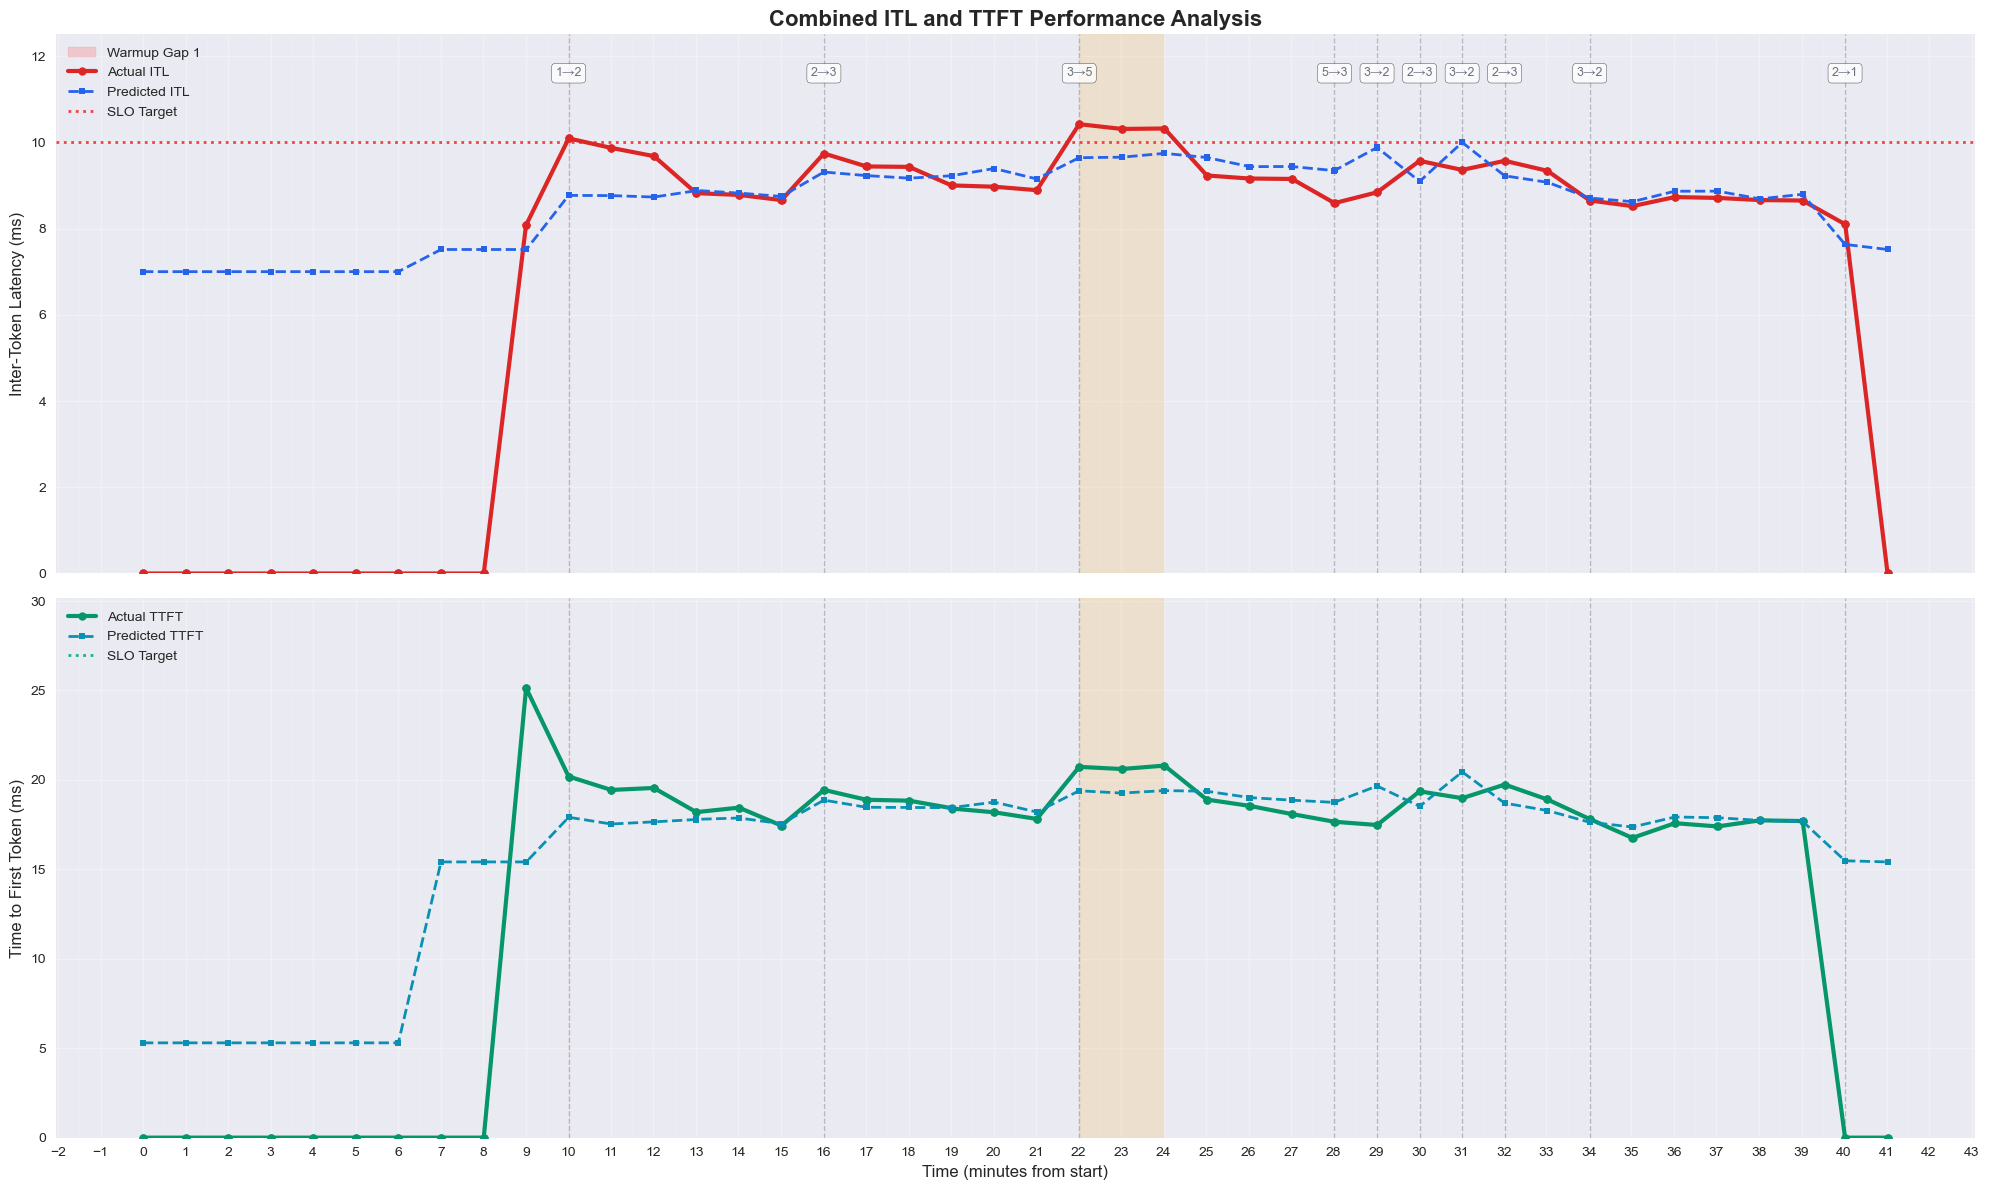

✅ Plot saved as 'experiments/20251024_233822_ttft_queuescorer_SLO_10_10_24/plots/combined_itl_ttft.png'


In [93]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12), sharex=True)

# ITL subplot
for i, gap in enumerate(warmup_gaps):
    color = ['red', 'orange', 'yellow'][i % 3]
    rect = Rectangle(
        (gap['start_time'], 0),
        gap['end_time'] - gap['start_time'],
        df['itlAverage'].max() * 1.2,
        alpha=0.15,
        color=color,
        label=f"Warmup Gap {i+1}" if i == 0 else ""
    )
    ax1.add_patch(rect)

ax1.plot(df['time_minutes'], df['itlAverage'], 'o-', 
         linewidth=3, markersize=6, color='#dc2626', label='Actual ITL', zorder=3)
ax1.plot(df['time_minutes'], df['itl'], 's--', 
         linewidth=2, markersize=4, color='#2563eb', label='Predicted ITL', zorder=3)
ax1.axhline(y=df['slo_itl'].iloc[0], color='#ef4444', 
            linestyle=':', linewidth=2, label='SLO Target', zorder=2)

for event in scaling_events:
    ax1.axvline(x=event['time'], color='#9ca3af', linestyle='--', alpha=0.7, linewidth=1, zorder=1)
    ax1.text(event['time'], df['itlAverage'].max() * 1.1, 
             f"{event['from_replicas']:.0f}→{event['to_replicas']:.0f}",
             ha='center', va='bottom', fontsize=9, color='#6b7280',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

ax1.set_ylabel('Inter-Token Latency (ms)', fontsize=12)
ax1.set_title('Combined ITL and TTFT Performance Analysis', fontweight='bold', fontsize=16)
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, df['itlAverage'].max() * 1.2)

# TTFT subplot
for i, gap in enumerate(warmup_gaps):
    color = ['red', 'orange', 'yellow'][i % 3]
    rect = Rectangle(
        (gap['start_time'], 0),
        gap['end_time'] - gap['start_time'],
        df['ttftAverage'].max() * 1.2,
        alpha=0.15,
        color=color
    )
    ax2.add_patch(rect)

ax2.plot(df['time_minutes'], df['ttftAverage'], 'o-', 
         linewidth=3, markersize=6, color='#059669', label='Actual TTFT', zorder=3)
ax2.plot(df['time_minutes'], df['ttft'], 's--', 
         linewidth=2, markersize=4, color='#0891b2', label='Predicted TTFT', zorder=3)
ax2.axhline(y=df['slo_ttft'].iloc[0], color='#10b981', 
            linestyle=':', linewidth=2, label='SLO Target', zorder=2)

for event in scaling_events:
    ax2.axvline(x=event['time'], color='#9ca3af', linestyle='--', alpha=0.7, linewidth=1, zorder=1)

ax2.set_xlabel('Time (minutes from start)', fontsize=12)
ax2.set_ylabel('Time to First Token (ms)', fontsize=12)
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, df['ttftAverage'].max() * 1.2)

# Set x-axis granularity (applies to both subplots since sharex=True)
ax2.xaxis.set_major_locator(MultipleLocator(X_MAJOR_TICK_INTERVAL))
ax2.xaxis.set_minor_locator(MultipleLocator(X_MINOR_TICK_INTERVAL))
ax1.grid(True, which='major', alpha=0.3, linewidth=1)
ax1.grid(True, which='minor', alpha=0.15, linewidth=0.5)
ax2.grid(True, which='major', alpha=0.3, linewidth=1)
ax2.grid(True, which='minor', alpha=0.15, linewidth=0.5)

plt.tight_layout()
plot_path = f'{EXPERIMENT_DIR}/plots/combined_itl_ttft.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Plot saved as '{plot_path}'")

## 10. Visualization: Combined ITL & TTFT Analysis

## 11. Statistical Analysis

In [94]:
print("="*60)
print("WVA PERFORMANCE ANALYSIS SUMMARY")
print("="*60)
print(f"\n📊 Experiment Overview:")
print(f"   Experiment ID: {EXPERIMENT_NAME}")
print(f"   Duration: {df['time_minutes'].max():.1f} minutes")
print(f"   Data points: {len(df)}")
print(f"   Scaling pattern: {df['numRep'].min():.0f} → {df['numRep'].max():.0f} replicas")
print(f"   Peak load: {df['rate'].max():.0f} rpm")
print(f"   SLO ITL: {df['slo_itl'].iloc[0]:.0f} ms")
print(f"   SLO TTFT: {df['slo_ttft'].iloc[0]:.0f} ms")

print(f"\n⚠️  Warmup Gap Analysis:")
for i, gap in enumerate(warmup_gaps, 1):
    print(f"\n   Gap {i} (t={gap['start_time']:.1f}-{gap['end_time']:.1f}min):")
    print(f"      Duration: {gap['duration']:.1f} minutes")
    print(f"      Peak ITL violation: {gap['peak_violation']:.2f} ms")
    print(f"      Average ITL: {gap['avg_tpot']:.2f} ms")
    print(f"      Average load: {gap['avg_load']:.0f} rpm")
    print(f"      SLO exceedance: {gap['avg_tpot'] - df['slo_itl'].iloc[0]:.2f} ms")

print(f"\n📈 ITL Performance Metrics:")
print(f"   Mean ITL: {df['itlAverage'].mean():.2f} ms")
print(f"   Median ITL: {df['itlAverage'].median():.2f} ms")
print(f"   Peak ITL: {df['itlAverage'].max():.2f} ms")
print(f"   Min ITL: {df['itlAverage'].min():.2f} ms")
print(f"   Std Dev: {df['itlAverage'].std():.2f} ms")

print(f"\n📈 TTFT Performance Metrics:")
print(f"   Mean TTFT: {df['ttftAverage'].mean():.2f} ms")
print(f"   Median TTFT: {df['ttftAverage'].median():.2f} ms")
print(f"   Peak TTFT: {df['ttftAverage'].max():.2f} ms")
print(f"   Min TTFT: {df['ttftAverage'].min():.2f} ms")
print(f"   Std Dev: {df['ttftAverage'].std():.2f} ms")

# SLO compliance
itl_violations = df[df['itlAverage'] > df['slo_itl']]
ttft_violations = df[df['ttftAverage'] > df['slo_ttft']]
itl_compliance_rate = (1 - len(itl_violations) / len(df)) * 100
ttft_compliance_rate = (1 - len(ttft_violations) / len(df)) * 100

print(f"\n✅ SLO Compliance:")
print(f"   ITL Compliance: {itl_compliance_rate:.1f}%")
print(f"   ITL Violations: {len(itl_violations)} / {len(df)} data points")
print(f"   TTFT Compliance: {ttft_compliance_rate:.1f}%")
print(f"   TTFT Violations: {len(ttft_violations)} / {len(df)} data points")

print(f"\n🔄 Scaling Events:")
for i, event in enumerate(scaling_events, 1):
    print(f"   {i}. t={event['time']:.1f}min: {event['from_replicas']:.0f} → {event['to_replicas']:.0f} replicas (load: {event['load']:.1f} rpm)")

print("\n" + "="*60)

# Save summary to file
summary_path = f'{EXPERIMENT_DIR}/analysis/summary.txt'
with open(summary_path, 'w') as f:
    f.write("="*60 + "\n")
    f.write("WVA PERFORMANCE ANALYSIS SUMMARY\n")
    f.write("="*60 + "\n")
    f.write(f"\nExperiment ID: {EXPERIMENT_NAME}\n")
    f.write(f"Duration: {df['time_minutes'].max():.1f} minutes\n")
    f.write(f"ITL Compliance: {itl_compliance_rate:.1f}%\n")
    f.write(f"TTFT Compliance: {ttft_compliance_rate:.1f}%\n")
    f.write(f"Peak Load: {df['rate'].max():.0f} rpm\n")
    f.write(f"Scaling Pattern: {df['numRep'].min():.0f} → {df['numRep'].max():.0f} replicas\n")

print(f"\n✅ Summary saved to '{summary_path}'")

WVA PERFORMANCE ANALYSIS SUMMARY

📊 Experiment Overview:
   Experiment ID: 20251024_233822
   Duration: 41.0 minutes
   Data points: 84
   Scaling pattern: 1 → 5 replicas
   Peak load: 3377 rpm
   SLO ITL: 10 ms
   SLO TTFT: 1000 ms

⚠️  Warmup Gap Analysis:

   Gap 1 (t=10.0-10.0min):
      Duration: 0.0 minutes
      Peak ITL violation: 10.09 ms
      Average ITL: 10.09 ms
      Average load: 832 rpm
      SLO exceedance: 0.09 ms

   Gap 2 (t=22.0-24.0min):
      Duration: 2.0 minutes
      Peak ITL violation: 10.42 ms
      Average ITL: 10.35 ms
      Average load: 3361 rpm
      SLO exceedance: 0.35 ms

📈 ITL Performance Metrics:
   Mean ITL: 6.98 ms
   Median ITL: 8.80 ms
   Peak ITL: 10.42 ms
   Min ITL: 0.00 ms
   Std Dev: 3.96 ms

📈 TTFT Performance Metrics:
   Mean TTFT: 13.92 ms
   Median TTFT: 17.95 ms
   Peak TTFT: 25.12 ms
   Min TTFT: 0.00 ms
   Std Dev: 8.45 ms

✅ SLO Compliance:
   ITL Compliance: 90.5%
   ITL Violations: 8 / 84 data points
   TTFT Compliance: 100.0%
  

## 12. Export Results

Export the processed data and analysis results for further use.

In [95]:
# Export processed data with phases
processed_csv = f'{EXPERIMENT_DIR}/data/processed_metrics.csv'
df.to_csv(processed_csv, index=False)
print(f"✅ Processed data exported to '{processed_csv}'")

# Export warmup gaps analysis
if warmup_gaps:
    gaps_df = pd.DataFrame(warmup_gaps)
    gaps_csv = f'{EXPERIMENT_DIR}/analysis/warmup_gaps.csv'
    gaps_df.to_csv(gaps_csv, index=False)
    print(f"✅ Warmup gaps analysis exported to '{gaps_csv}'")

# Export scaling events
if scaling_events:
    events_df = pd.DataFrame(scaling_events)
    events_csv = f'{EXPERIMENT_DIR}/analysis/scaling_events.csv'
    events_df.to_csv(events_csv, index=False)
    print(f"✅ Scaling events exported to '{events_csv}'")

# Copy original log file to experiment directory
import shutil
log_copy = f'{EXPERIMENT_DIR}/data/original_log.txt'
shutil.copy(LOG_FILE, log_copy)
print(f"✅ Original log file copied to '{log_copy}'")

# Create experiment manifest
manifest_path = f'{EXPERIMENT_DIR}/manifest.txt'
with open(manifest_path, 'w') as f:
    f.write(f"Experiment ID: {EXPERIMENT_NAME}\n")
    f.write(f"Created: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Log File: {LOG_FILE}\n")
    f.write(f"Duration: {df['time_minutes'].max():.1f} minutes\n")
    f.write(f"Data Points: {len(df)}\n")
    f.write(f"\nDirectory Structure:\n")
    f.write(f"  - data/: Raw and processed data files\n")
    f.write(f"  - plots/: Generated visualization plots\n")
    f.write(f"  - analysis/: Statistical analysis results\n")
    
print(f"✅ Manifest created at '{manifest_path}'")
print(f"\n📁 Experiment directory: {EXPERIMENT_DIR}")
print(f"   All outputs have been organized in subdirectories")

✅ Processed data exported to 'experiments/20251024_233822_ttft_queuescorer_SLO_10_10_24/data/processed_metrics.csv'
✅ Warmup gaps analysis exported to 'experiments/20251024_233822_ttft_queuescorer_SLO_10_10_24/analysis/warmup_gaps.csv'
✅ Scaling events exported to 'experiments/20251024_233822_ttft_queuescorer_SLO_10_10_24/analysis/scaling_events.csv'
✅ Original log file copied to 'experiments/20251024_233822_ttft_queuescorer_SLO_10_10_24/data/original_log.txt'
✅ Manifest created at 'experiments/20251024_233822_ttft_queuescorer_SLO_10_10_24/manifest.txt'

📁 Experiment directory: experiments/20251024_233822_ttft_queuescorer_SLO_10_10_24
   All outputs have been organized in subdirectories


## 13. Custom Analysis (Optional)

Use this cell for custom queries and exploration.

In [96]:
# Example: Find periods where predicted ITL underestimated actual ITL
itl_underestimation = df[df['itlAverage'] > df['itl']]
print("ITL Controller Underestimation Analysis:")
print(f"Occurred in {len(itl_underestimation)} / {len(df)} samples ({len(itl_underestimation)/len(df)*100:.1f}%)")
print(f"Average underestimation: {(itl_underestimation['itlAverage'] - itl_underestimation['itl']).mean():.2f} ms")

# Show samples with largest ITL underestimation
print("\nTop 5 largest ITL underestimations:")
itl_underestimation['gap'] = itl_underestimation['itlAverage'] - itl_underestimation['itl']
display(itl_underestimation.nlargest(5, 'gap')[['time_minutes', 'itlAverage', 'itl', 'gap', 'numRep', 'rate']])

# Example: Find periods where predicted TTFT underestimated actual TTFT
ttft_underestimation = df[df['ttftAverage'] > df['ttft']]
print("\nTTFT Controller Underestimation Analysis:")
print(f"Occurred in {len(ttft_underestimation)} / {len(df)} samples ({len(ttft_underestimation)/len(df)*100:.1f}%)")
print(f"Average underestimation: {(ttft_underestimation['ttftAverage'] - ttft_underestimation['ttft']).mean():.2f} ms")

# Show samples with largest TTFT underestimation
print("\nTop 5 largest TTFT underestimations:")
ttft_underestimation['gap'] = ttft_underestimation['ttftAverage'] - ttft_underestimation['ttft']
display(ttft_underestimation.nlargest(5, 'gap')[['time_minutes', 'ttftAverage', 'ttft', 'gap', 'numRep', 'rate']])

ITL Controller Underestimation Analysis:
Occurred in 28 / 84 samples (33.3%)
Average underestimation: 0.60 ms

Top 5 largest ITL underestimations:


/var/folders/w8/8n63220d7qnd2nmdqckjtls40000gn/T/ipykernel_25881/201466315.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  itl_underestimation['gap'] = itl_underestimation['itlAverage'] - itl_underestimation['itl']


,time_minutes,itlAverage,itl,gap,numRep,rate
20,10.007200,10.09,8.768532,1.321468,2,831.90
21,10.012000,10.09,8.768532,1.321468,2,831.90
22,11.007750,9.87,8.764071,1.105929,2,817.24
23,11.012467,9.87,8.764071,1.105929,2,817.24
24,12.008300,9.68,8.730743,0.949257,2,817.34



TTFT Controller Underestimation Analysis:
Occurred in 36 / 84 samples (42.9%)
Average underestimation: 1.38 ms

Top 5 largest TTFT underestimations:


/var/folders/w8/8n63220d7qnd2nmdqckjtls40000gn/T/ipykernel_25881/201466315.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ttft_underestimation['gap'] = ttft_underestimation['ttftAverage'] - ttft_underestimation['ttft']


,time_minutes,ttftAverage,ttft,gap,numRep,rate
18,9.006633,25.12,15.415337,9.704663,1,0.00
19,9.011583,25.12,15.415337,9.704663,1,0.00
20,10.007200,20.19,17.911339,2.278661,2,831.90
21,10.012000,20.19,17.911339,2.278661,2,831.90
22,11.007750,19.44,17.536041,1.903959,2,817.24


## 14. Experiment Summary

Review the complete experiment directory structure and outputs.

In [97]:
import os
from pathlib import Path

print("="*70)
print(f"EXPERIMENT {EXPERIMENT_NAME} - COMPLETE")
print("="*70)

print(f"\n📁 Experiment Directory: {EXPERIMENT_DIR}")
print("\nDirectory Structure:")

# Walk through the experiment directory
for root, dirs, files in os.walk(EXPERIMENT_DIR):
    level = root.replace(EXPERIMENT_DIR, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    for file in files:
        file_path = os.path.join(root, file)
        file_size = os.path.getsize(file_path)
        print(f'{subindent}📄 {file} ({file_size:,} bytes)')

print("\n" + "="*70)
print("Generated Outputs:")
print("="*70)

print("\n📊 Plots (6 visualizations):")
print("   1. itl_analysis.png - ITL performance with warmup gaps")
print("   2. ttft_analysis.png - TTFT performance with warmup gaps")
print("   3. load_pattern.png - Arrival rate evolution")
print("   4. itl_replicas_timeline.png - ITL vs replica scaling")
print("   5. ttft_replicas_timeline.png - TTFT vs replica scaling")
print("   6. combined_itl_ttft.png - Combined ITL & TTFT analysis")

print("\n📈 Data Files:")
print("   • extracted_metrics.csv - Raw extracted metrics")
print("   • processed_metrics.csv - Processed data with time calculations")
print("   • original_log.txt - Copy of original log file")

print("\n📋 Analysis Files:")
print("   • warmup_gaps.csv - Detected warmup gap statistics")
print("   • scaling_events.csv - Scaling event log")
print("   • summary.txt - Text summary of key findings")

print("\n📝 Experiment Metadata:")
print("   • manifest.txt - Experiment configuration and metadata")

print("\n" + "="*70)
print(f"✅ All outputs saved to: {EXPERIMENT_DIR}")
print("="*70)

EXPERIMENT 20251024_233822 - COMPLETE

📁 Experiment Directory: experiments/20251024_233822_ttft_queuescorer_SLO_10_10_24

Directory Structure:
20251024_233822_ttft_queuescorer_SLO_10_10_24/
  📄 manifest.txt (302 bytes)
  📄 extracted_metrics.csv (6,329 bytes)
  analysis/
    📄 summary.txt (310 bytes)
    📄 warmup_gaps.csv (214 bytes)
    📄 scaling_events.csv (306 bytes)
  data/
    📄 processed_metrics.csv (8,554 bytes)
    📄 original_log.txt (471,907 bytes)
  plots/
    📄 itl_analysis.png (393,398 bytes)
    📄 ttft_replicas_timeline.png (231,142 bytes)
    📄 itl_replicas_timeline.png (349,669 bytes)
    📄 combined_itl_ttft.png (584,172 bytes)
    📄 load_pattern.png (256,513 bytes)
    📄 ttft_analysis.png (402,268 bytes)

Generated Outputs:

📊 Plots (6 visualizations):
   1. itl_analysis.png - ITL performance with warmup gaps
   2. ttft_analysis.png - TTFT performance with warmup gaps
   3. load_pattern.png - Arrival rate evolution
   4. itl_replicas_timeline.png - ITL vs replica scaling

## 15. Calibration Analysis - Understanding the ITL Gap

This section analyzes the gap between predicted and observed ITL to identify calibration opportunities.

In [98]:
print("="*70)
print("CALIBRATION ANALYSIS: ITL Prediction Gap")
print("="*70)

# Calculate prediction error
df['itl_error'] = df['itlAverage'] - df['itl']
df['itl_error_pct'] = (df['itl_error'] / df['itl']) * 100

# Calculate effective batch size (approximation)
# effectiveBatch ≈ rate per replica / service rate
# For simplicity, we'll use a proxy: rate/numRep
df['rate_per_replica'] = df['rate'] / df['numRep']

print(f"\n📊 Prediction Error Statistics:")
print(f"   Mean Error: {df['itl_error'].mean():.2f} ms")
print(f"   Median Error: {df['itl_error'].median():.2f} ms")
print(f"   Std Dev Error: {df['itl_error'].std():.2f} ms")
print(f"   Mean % Error: {df['itl_error_pct'].mean():.1f}%")
print(f"   Max Underestimate: {df['itl_error'].max():.2f} ms")
print(f"   Max Overestimate: {df['itl_error'].min():.2f} ms")

# Identify systematic bias
overestimates = df[df['itl_error'] < 0]
underestimates = df[df['itl_error'] > 0]

print(f"\n⚖️  Bias Analysis:")
print(f"   Overestimates: {len(overestimates)} / {len(df)} ({len(overestimates)/len(df)*100:.1f}%)")
print(f"   Underestimates: {len(underestimates)} / {len(df)} ({len(underestimates)/len(df)*100:.1f}%)")

if len(underestimates) > len(overestimates):
    print(f"   ⚠️  System tends to UNDERESTIMATE ITL (optimistic)")
else:
    print(f"   ℹ️  System tends to OVERESTIMATE ITL (conservative)")

# Correlation with load
print(f"\n🔗 Correlation Analysis:")
print(f"   Error vs Rate: {df[['itl_error', 'rate']].corr().iloc[0,1]:.3f}")
print(f"   Error vs Replicas: {df[['itl_error', 'numRep']].corr().iloc[0,1]:.3f}")
print(f"   Error vs Rate/Replica: {df[['itl_error', 'rate_per_replica']].corr().iloc[0,1]:.3f}")

# Identify worst predictions
print(f"\n❌ Top 5 Worst Predictions (Largest Underestimates):")
worst = df.nlargest(5, 'itl_error')[['time_minutes', 'itlAverage', 'itl', 'itl_error', 
                                       'rate', 'numRep', 'rate_per_replica']]
display(worst)

print("\n" + "="*70)
print("💡 Calibration Opportunities:")
print("="*70)
print("1. Linear Regression: Fit alpha/beta to observed ITL vs load")
print("2. Query Prometheus: Get last 1h of ITL observations")
print("3. Filter Outliers: Remove anomalous points (> 2.5 std dev)")
print("4. Update Parameters: Use calibrated alpha/beta for predictions")
print(f"5. Expected Improvement: Reduce mean error from {df['itl_error'].mean():.2f}ms")
print("="*70)

CALIBRATION ANALYSIS: ITL Prediction Gap

📊 Prediction Error Statistics:
   Mean Error: -1.63 ms
   Median Error: -0.14 ms
   Std Dev Error: 3.15 ms
   Mean % Error: -22.8%
   Max Underestimate: 1.32 ms
   Max Overestimate: -7.51 ms

⚖️  Bias Analysis:
   Overestimates: 56 / 84 (66.7%)
   Underestimates: 28 / 84 (33.3%)
   ℹ️  System tends to OVERESTIMATE ITL (conservative)

🔗 Correlation Analysis:
   Error vs Rate: 0.605
   Error vs Replicas: 0.590
   Error vs Rate/Replica: 0.787

❌ Top 5 Worst Predictions (Largest Underestimates):


,time_minutes,itlAverage,itl,itl_error,rate,numRep,rate_per_replica
20,10.007200,10.09,8.768532,1.321468,831.90,2,415.95
21,10.012000,10.09,8.768532,1.321468,831.90,2,415.95
22,11.007750,9.87,8.764071,1.105929,817.24,2,408.62
23,11.012467,9.87,8.764071,1.105929,817.24,2,408.62
24,12.008300,9.68,8.730743,0.949257,817.34,2,408.67



💡 Calibration Opportunities:
1. Linear Regression: Fit alpha/beta to observed ITL vs load
2. Query Prometheus: Get last 1h of ITL observations
3. Filter Outliers: Remove anomalous points (> 2.5 std dev)
4. Update Parameters: Use calibrated alpha/beta for predictions
5. Expected Improvement: Reduce mean error from -1.63ms


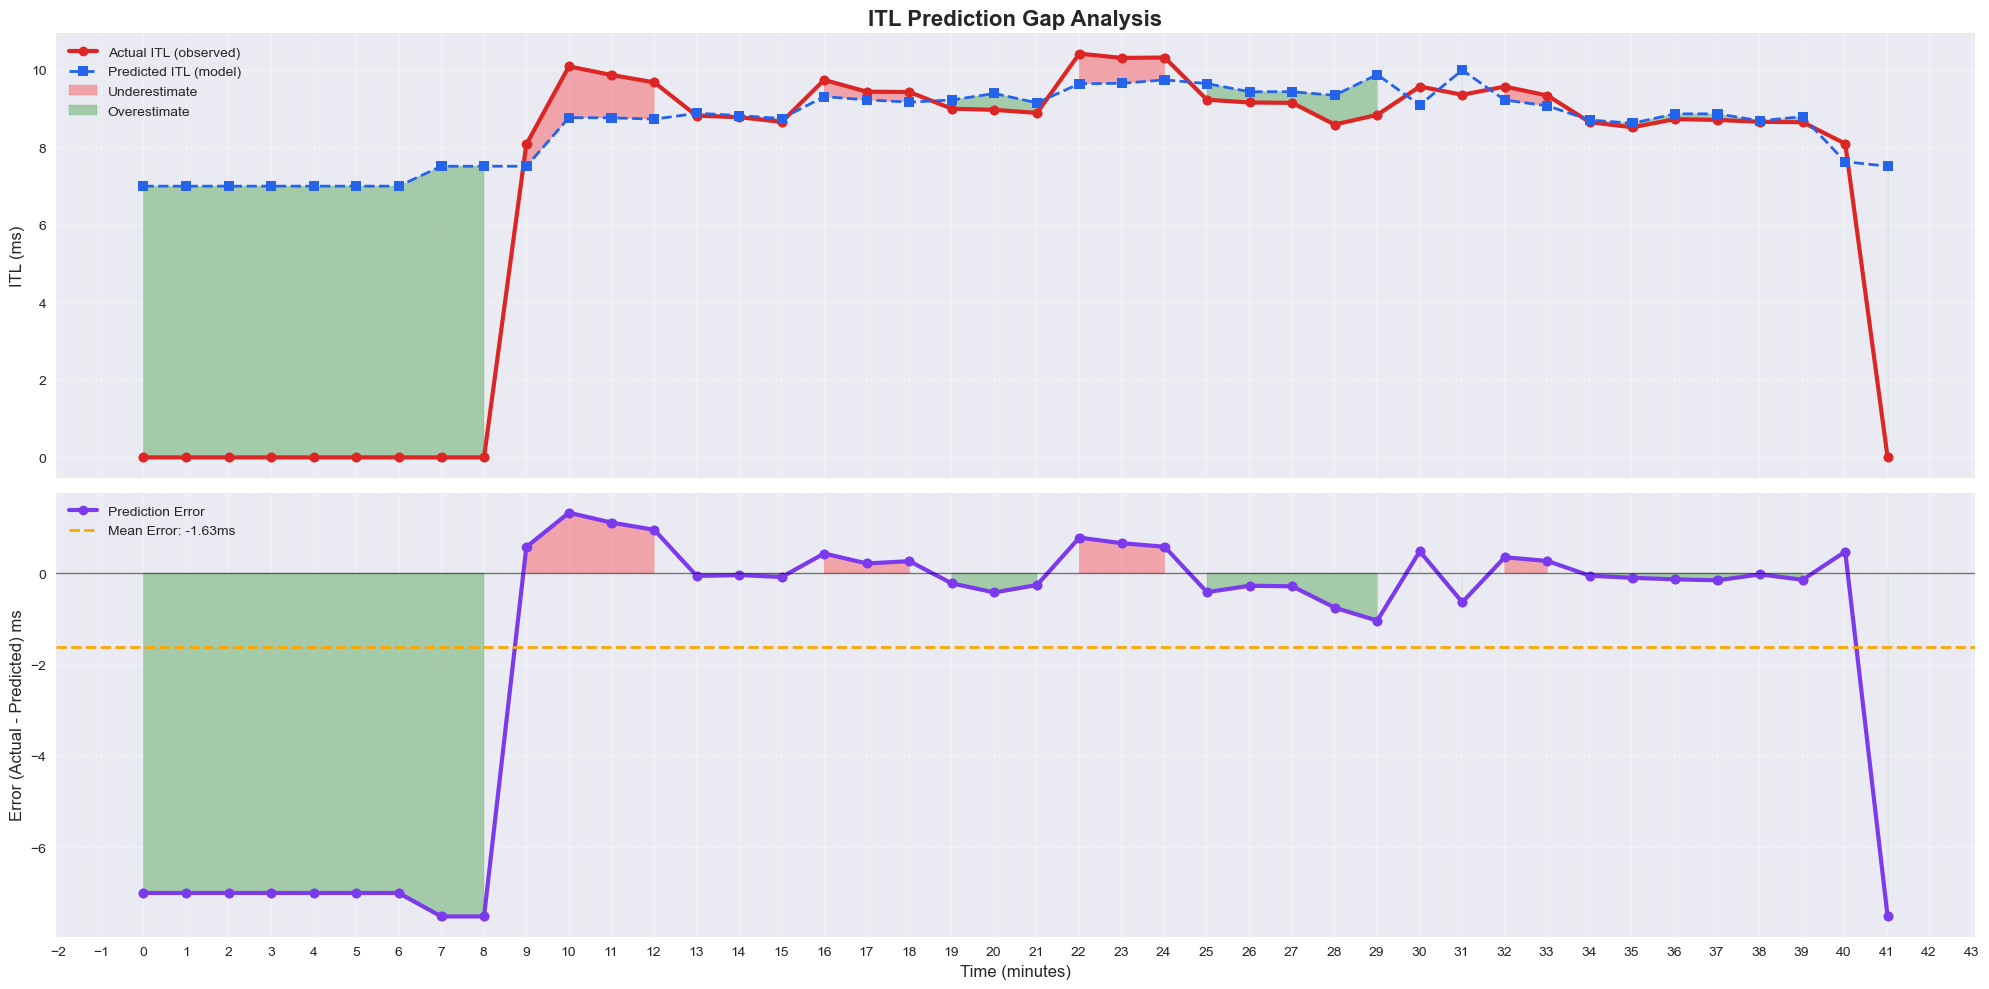

✅ Plot saved as 'experiments/20251024_233822_ttft_queuescorer_SLO_10_10_24/plots/calibration_gap_analysis.png'


In [99]:
# Visualize prediction error over time
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True)

# Top: Predicted vs Actual ITL
ax1.plot(df['time_minutes'], df['itlAverage'], 'o-', 
         linewidth=3, color='#dc2626', label='Actual ITL (observed)', zorder=3)
ax1.plot(df['time_minutes'], df['itl'], 's--', 
         linewidth=2, color='#2563eb', label='Predicted ITL (model)', zorder=3)
ax1.fill_between(df['time_minutes'], df['itl'], df['itlAverage'], 
                  where=(df['itlAverage'] > df['itl']), 
                  alpha=0.3, color='red', label='Underestimate')
ax1.fill_between(df['time_minutes'], df['itl'], df['itlAverage'], 
                  where=(df['itlAverage'] <= df['itl']), 
                  alpha=0.3, color='green', label='Overestimate')
ax1.set_ylabel('ITL (ms)', fontsize=12)
ax1.set_title('ITL Prediction Gap Analysis', fontweight='bold', fontsize=16)
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Bottom: Prediction Error
ax2.plot(df['time_minutes'], df['itl_error'], 'o-', 
         linewidth=3, color='#7c3aed', label='Prediction Error')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax2.axhline(y=df['itl_error'].mean(), color='orange', linestyle='--', 
            linewidth=2, label=f'Mean Error: {df["itl_error"].mean():.2f}ms')
ax2.fill_between(df['time_minutes'], 0, df['itl_error'], 
                  where=(df['itl_error'] > 0), alpha=0.3, color='red')
ax2.fill_between(df['time_minutes'], 0, df['itl_error'], 
                  where=(df['itl_error'] <= 0), alpha=0.3, color='green')
ax2.set_xlabel('Time (minutes)', fontsize=12)
ax2.set_ylabel('Error (Actual - Predicted) ms', fontsize=12)
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

# Set x-axis granularity
ax2.xaxis.set_major_locator(MultipleLocator(X_MAJOR_TICK_INTERVAL))
ax2.xaxis.set_minor_locator(MultipleLocator(X_MINOR_TICK_INTERVAL))
ax1.grid(True, which='major', alpha=0.3, linewidth=1)
ax1.grid(True, which='minor', alpha=0.15, linewidth=0.5)
ax2.grid(True, which='major', alpha=0.3, linewidth=1)
ax2.grid(True, which='minor', alpha=0.15, linewidth=0.5)

plt.tight_layout()
plot_path = f'{EXPERIMENT_DIR}/plots/calibration_gap_analysis.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Plot saved as '{plot_path}'")

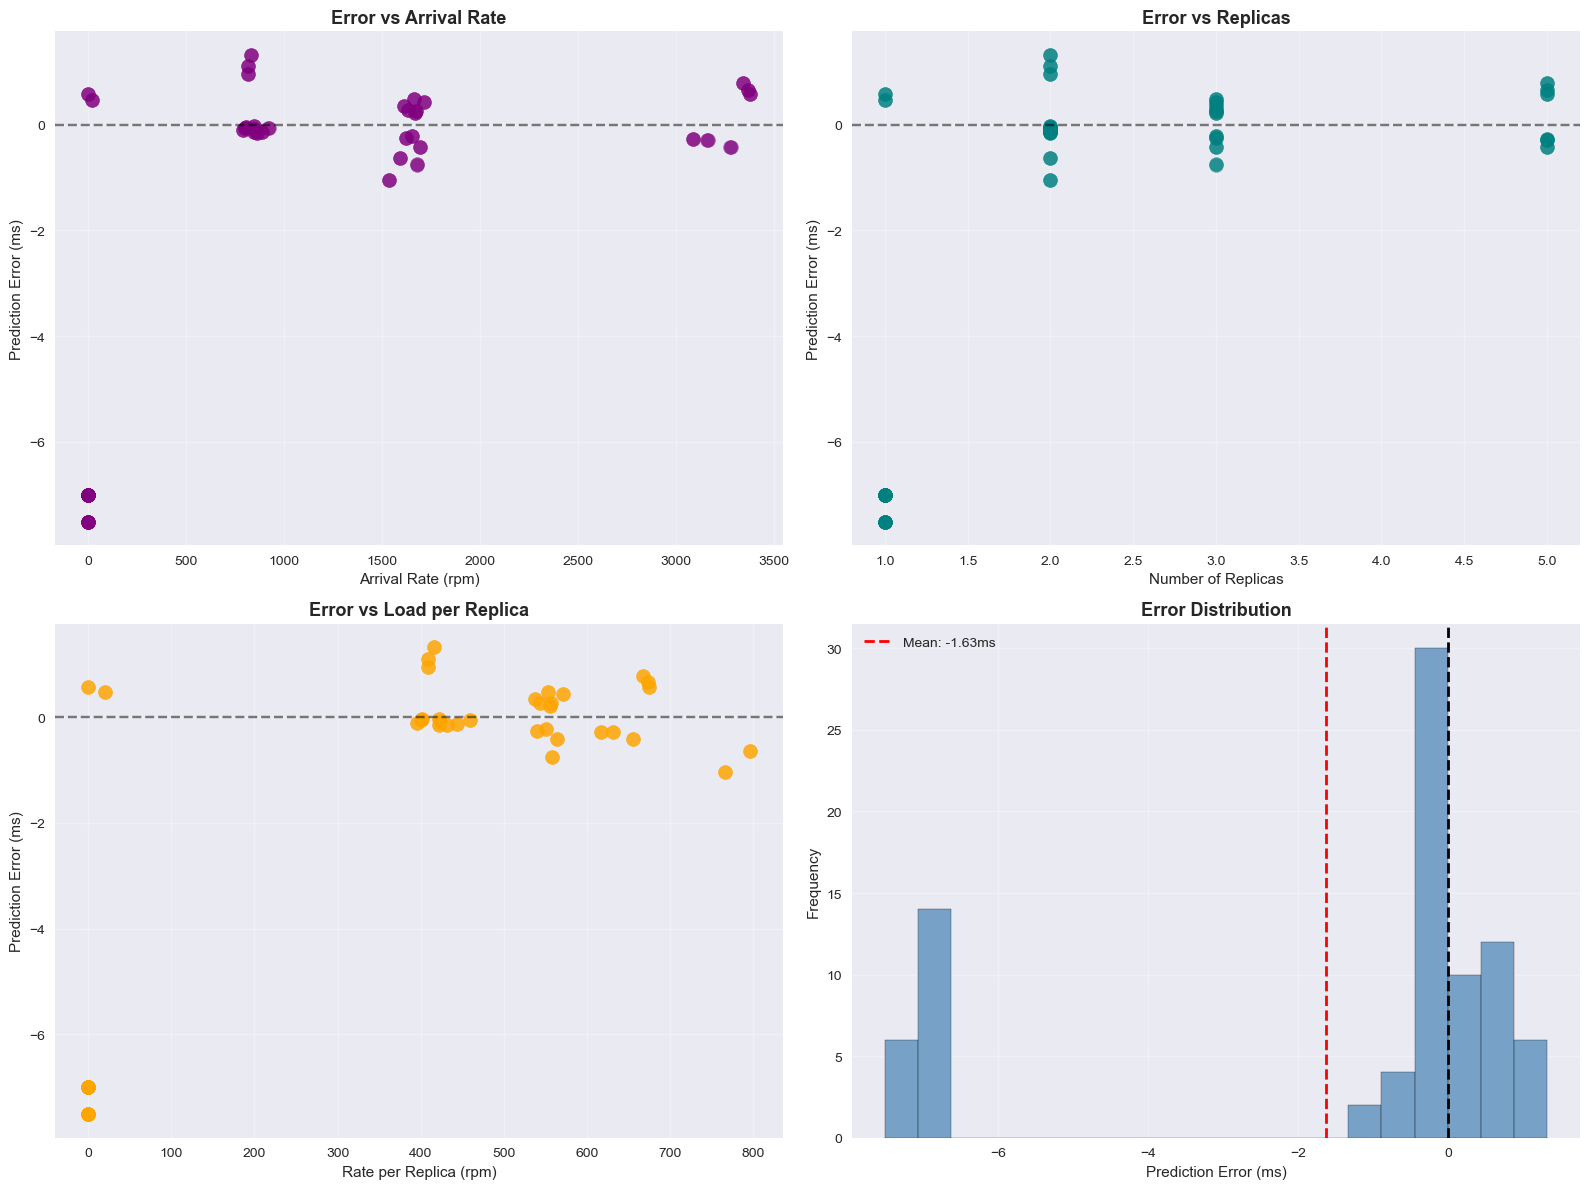

✅ Plot saved as 'experiments/20251024_233822_ttft_queuescorer_SLO_10_10_24/plots/calibration_correlation_analysis.png'


In [100]:
# Scatter plot: Error vs Load characteristics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Error vs Arrival Rate
axes[0, 0].scatter(df['rate'], df['itl_error'], alpha=0.6, s=100, c='purple')
axes[0, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[0, 0].set_xlabel('Arrival Rate (rpm)', fontsize=11)
axes[0, 0].set_ylabel('Prediction Error (ms)', fontsize=11)
axes[0, 0].set_title('Error vs Arrival Rate', fontweight='bold', fontsize=13)
axes[0, 0].grid(True, alpha=0.3)

# Error vs Number of Replicas
axes[0, 1].scatter(df['numRep'], df['itl_error'], alpha=0.6, s=100, c='teal')
axes[0, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[0, 1].set_xlabel('Number of Replicas', fontsize=11)
axes[0, 1].set_ylabel('Prediction Error (ms)', fontsize=11)
axes[0, 1].set_title('Error vs Replicas', fontweight='bold', fontsize=13)
axes[0, 1].grid(True, alpha=0.3)

# Error vs Rate per Replica (proxy for batch size)
axes[1, 0].scatter(df['rate_per_replica'], df['itl_error'], alpha=0.6, s=100, c='orange')
axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1, 0].set_xlabel('Rate per Replica (rpm)', fontsize=11)
axes[1, 0].set_ylabel('Prediction Error (ms)', fontsize=11)
axes[1, 0].set_title('Error vs Load per Replica', fontweight='bold', fontsize=13)
axes[1, 0].grid(True, alpha=0.3)

# Error distribution histogram
axes[1, 1].hist(df['itl_error'], bins=20, color='steelblue', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(x=0, color='black', linestyle='--', linewidth=2)
axes[1, 1].axvline(x=df['itl_error'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {df["itl_error"].mean():.2f}ms')
axes[1, 1].set_xlabel('Prediction Error (ms)', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title('Error Distribution', fontweight='bold', fontsize=13)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plot_path = f'{EXPERIMENT_DIR}/plots/calibration_correlation_analysis.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Plot saved as '{plot_path}'")

## 16. MM1K vs MD1K Model Comparison

Compare the performance of two queue models:
- **MM1K**: M/M/1/K model (exponential service times)
- **MD1K**: M/D/1/K model (deterministic service times)

This analysis loads data from two experiments and compares their prediction accuracy.

In [101]:
# Import required libraries for MM1K vs MD1K comparison
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats
from IPython.display import display
import pandas as pd

In [102]:
# Load MM1K data (ttft experiment)
mm1k_file = "experiments/20251024_232539_ttft_queuescorer_SLO_10_10_24/extracted_metrics_ttft.csv"
mm1k_df = pd.read_csv(mm1k_file)
mm1k_df['model'] = 'MM1K'
print(f"MM1K data loaded: {len(mm1k_df)} records")

# Load MD1K data (new experiment)
md1k_file = "experiments/20251024_232458_md1k_logs/extracted_metrics_mdk1.csv"  # Update with actual filename
md1k_df = pd.read_csv(md1k_file)
md1k_df['model'] = 'MD1K'
print(f"MD1K data loaded: {len(md1k_df)} records")

# Display data structure
print("\nMM1K columns:", mm1k_df.columns.tolist())
print("MD1K columns:", md1k_df.columns.tolist())

# Show sample data
print("\n--- MM1K Sample ---")
display(mm1k_df.head(3))
print("\n--- MD1K Sample ---")
display(md1k_df.head(3))

MM1K data loaded: 84 records
MD1K data loaded: 94 records

MM1K columns: ['timestamp', 'itlAverage', 'ttftAverage', 'rate', 'inTk', 'outTk', 'numRep', 'itl', 'ttft', 'slo_itl', 'slo_ttft', 'model']
MD1K columns: ['timestamp', 'itlAverage', 'ttftAverage', 'rate', 'inTk', 'outTk', 'numRep', 'itl', 'ttft', 'slo_itl', 'slo_ttft', 'model']

--- MM1K Sample ---


,timestamp,itlAverage,ttftAverage,rate,inTk,outTk,numRep,itl,ttft,slo_itl,slo_ttft,model
0,2025-10-24T13:41:38.691Z,0.0,0.0,0.0,0,0,1,7.0,5.3,10,1000,MM1K
1,2025-10-24T13:41:38.705Z,0.0,0.0,0.0,0,0,1,7.0,5.3,10,1000,MM1K
2,2025-10-24T13:42:38.711Z,0.0,0.0,0.0,0,0,1,7.0,5.3,10,1000,MM1K



--- MD1K Sample ---


,timestamp,itlAverage,ttftAverage,rate,inTk,outTk,numRep,itl,ttft,slo_itl,slo_ttft,model
0,2025-10-25T02:30:48.038Z,0.0,0.0,0.0,0,0,1,7.514,15.415337,10,1000,MD1K
1,2025-10-25T02:30:48.055Z,0.0,0.0,0.0,0,0,1,7.514,15.415337,10,1000,MD1K
2,2025-10-25T02:31:48.059Z,0.0,0.0,0.0,0,0,1,7.514,15.415337,10,1000,MD1K


In [103]:
# Combine datasets for comparison
combined_df = pd.concat([mm1k_df, md1k_df], ignore_index=True)

# Column mapping: 
# - ttftAverage = actual measured TTFT
# - ttft = predicted TTFT from queue model
# - itlAverage = actual measured ITL  
# - itl = predicted ITL from queue model

# Filter out rows with zero actual values (no traffic yet)
combined_df = combined_df[
    (combined_df['ttftAverage'] > 0) & 
    (combined_df['itlAverage'] > 0)
].copy()

print(f"Filtered to {len(combined_df)} records with non-zero measurements")
print(f"  MM1K: {len(combined_df[combined_df['model']=='MM1K'])} records")
print(f"  MD1K: {len(combined_df[combined_df['model']=='MD1K'])} records")

# Calculate prediction errors for TTFT
combined_df['ttft_error'] = combined_df['ttftAverage'] - combined_df['ttft']
combined_df['ttft_error_pct'] = (combined_df['ttft_error'] / combined_df['ttftAverage']) * 100
combined_df['ttft_abs_error'] = combined_df['ttft_error'].abs()
combined_df['ttft_abs_error_pct'] = combined_df['ttft_error_pct'].abs()

# Calculate prediction errors for ITL
combined_df['itl_error'] = combined_df['itlAverage'] - combined_df['itl']
combined_df['itl_error_pct'] = (combined_df['itl_error'] / combined_df['itlAverage']) * 100
combined_df['itl_abs_error'] = combined_df['itl_error'].abs()
combined_df['itl_abs_error_pct'] = combined_df['itl_error_pct'].abs()

print("\n✅ Combined dataset created with error metrics")
print(f"Error columns: {[col for col in combined_df.columns if 'error' in col]}")

Filtered to 124 records with non-zero measurements
  MM1K: 62 records
  MD1K: 62 records

✅ Combined dataset created with error metrics
Error columns: ['ttft_error', 'ttft_error_pct', 'ttft_abs_error', 'ttft_abs_error_pct', 'itl_error', 'itl_error_pct', 'itl_abs_error', 'itl_abs_error_pct']


In [104]:
# Split combined data back into model-specific dataframes for analysis
mm1k_filtered = combined_df[combined_df['model'] == 'MM1K'].copy()
md1k_filtered = combined_df[combined_df['model'] == 'MD1K'].copy()

# Statistical comparison of prediction accuracy
comparison_stats = combined_df.groupby('model').agg({
    'ttft_abs_error': ['mean', 'std', 'median', 'min', 'max'],
    'ttft_abs_error_pct': ['mean', 'std', 'median'],
    'itl_abs_error': ['mean', 'std', 'median', 'min', 'max'],
    'itl_abs_error_pct': ['mean', 'std', 'median']
}).round(3)

print("=" * 80)
print("PREDICTION ACCURACY COMPARISON: MM1K vs MD1K")
print("=" * 80)
display(comparison_stats)

# Calculate improvement
mm1k_ttft_error = comparison_stats.loc['MM1K', ('ttft_abs_error_pct', 'mean')]
md1k_ttft_error = comparison_stats.loc['MD1K', ('ttft_abs_error_pct', 'mean')]
ttft_improvement = ((mm1k_ttft_error - md1k_ttft_error) / mm1k_ttft_error) * 100

mm1k_itl_error = comparison_stats.loc['MM1K', ('itl_abs_error_pct', 'mean')]
md1k_itl_error = comparison_stats.loc['MD1K', ('itl_abs_error_pct', 'mean')]
itl_improvement = ((mm1k_itl_error - md1k_itl_error) / mm1k_itl_error) * 100

print(f"\n{'=' * 80}")
print("IMPROVEMENT SUMMARY")
print(f"{'=' * 80}")
print(f"TTFT Error Reduction: {ttft_improvement:.1f}%")
print(f"  MM1K: {mm1k_ttft_error:.2f}% error | MD1K: {md1k_ttft_error:.2f}% error")
print(f"\nITL Error Reduction: {itl_improvement:.1f}%")
print(f"  MM1K: {mm1k_itl_error:.2f}% error | MD1K: {md1k_itl_error:.2f}% error")

PREDICTION ACCURACY COMPARISON: MM1K vs MD1K


ttft_abs_error                             ttft_abs_error_pct         \
                mean    std median    min    max               mean    std   
model                                                                        
MD1K           0.801  0.503  0.658  0.034  2.169              4.235  2.653   
MM1K           1.093  1.706  0.580  0.002  9.705              5.348  6.934   

             itl_abs_error                             itl_abs_error_pct  \
      median          mean    std median    min    max              mean   
model                                                                      
MD1K   3.586         0.418  0.302  0.423  0.012  1.337             4.482   
MM1K   3.144         0.422  0.340  0.288  0.028  1.321             4.485   

                     
         std median  
model                
MD1K   3.321  4.366  
MM1K   3.511  3.149


IMPROVEMENT SUMMARY
TTFT Error Reduction: 20.8%
  MM1K: 5.35% error | MD1K: 4.24% error

ITL Error Reduction: 0.1%
  MM1K: 4.49% error | MD1K: 4.48% error


In [105]:
# Visualization: Side-by-side comparison of errors
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('TTFT Absolute Error', 'TTFT Error %',
                    'ITL Absolute Error', 'ITL Error %'),
    vertical_spacing=0.12,
    horizontal_spacing=0.1
)

# TTFT Absolute Error
fig.add_trace(
    go.Box(y=mm1k_filtered['ttft_abs_error'], name='MM1K', marker_color='#FF6B6B'),
    row=1, col=1
)
fig.add_trace(
    go.Box(y=md1k_filtered['ttft_abs_error'], name='MD1K', marker_color='#4ECDC4'),
    row=1, col=1
)

# TTFT Error %
fig.add_trace(
    go.Box(y=mm1k_filtered['ttft_abs_error_pct'], name='MM1K', marker_color='#FF6B6B', showlegend=False),
    row=1, col=2
)
fig.add_trace(
    go.Box(y=md1k_filtered['ttft_abs_error_pct'], name='MD1K', marker_color='#4ECDC4', showlegend=False),
    row=1, col=2
)

# ITL Absolute Error
fig.add_trace(
    go.Box(y=mm1k_filtered['itl_abs_error'], name='MM1K', marker_color='#FF6B6B', showlegend=False),
    row=2, col=1
)
fig.add_trace(
    go.Box(y=md1k_filtered['itl_abs_error'], name='MD1K', marker_color='#4ECDC4', showlegend=False),
    row=2, col=1
)

# ITL Error %
fig.add_trace(
    go.Box(y=mm1k_filtered['itl_abs_error_pct'], name='MM1K', marker_color='#FF6B6B', showlegend=False),
    row=2, col=2
)
fig.add_trace(
    go.Box(y=md1k_filtered['itl_abs_error_pct'], name='MD1K', marker_color='#4ECDC4', showlegend=False),
    row=2, col=2
)

fig.update_xaxes(title_text="Model", row=1, col=1)
fig.update_xaxes(title_text="Model", row=1, col=2)
fig.update_xaxes(title_text="Model", row=2, col=1)
fig.update_xaxes(title_text="Model", row=2, col=2)

fig.update_yaxes(title_text="Error (ms)", row=1, col=1)
fig.update_yaxes(title_text="Error (%)", row=1, col=2)
fig.update_yaxes(title_text="Error (ms)", row=2, col=1)
fig.update_yaxes(title_text="Error (%)", row=2, col=2)

fig.update_layout(
    title_text="MM1K vs MD1K: Prediction Error Comparison",
    height=700,
    showlegend=True,
    template='plotly_white'
)

fig.show()

In [106]:
# Scatter plot: Predicted vs Actual for both models
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('TTFT: Predicted vs Actual', 'ITL: Predicted vs Actual'),
    horizontal_spacing=0.12
)

# TTFT comparison
fig.add_trace(
    go.Scatter(
        x=mm1k_filtered['ttftAverage'],  # Actual measured
        y=mm1k_filtered['ttft'],         # Predicted by model
        mode='markers',
        name='MM1K',
        marker=dict(color='#FF6B6B', size=6, opacity=0.6),
        text=mm1k_filtered['timestamp'],
        hovertemplate='<b>MM1K</b><br>Actual: %{x:.2f} ms<br>Predicted: %{y:.2f} ms<extra></extra>'
    ),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=md1k_filtered['ttftAverage'],  # Actual measured
        y=md1k_filtered['ttft'],         # Predicted by model
        mode='markers',
        name='MD1K',
        marker=dict(color='#4ECDC4', size=6, opacity=0.6),
        text=md1k_filtered['timestamp'],
        hovertemplate='<b>MD1K</b><br>Actual: %{x:.2f} ms<br>Predicted: %{y:.2f} ms<extra></extra>'
    ),
    row=1, col=1
)

# Add perfect prediction line for TTFT
ttft_range = [combined_df['ttftAverage'].min(), combined_df['ttftAverage'].max()]
fig.add_trace(
    go.Scatter(
        x=ttft_range,
        y=ttft_range,
        mode='lines',
        name='Perfect Prediction',
        line=dict(color='gray', dash='dash'),
        showlegend=True
    ),
    row=1, col=1
)

# ITL comparison
fig.add_trace(
    go.Scatter(
        x=mm1k_filtered['itlAverage'],  # Actual measured
        y=mm1k_filtered['itl'],         # Predicted by model
        mode='markers',
        name='MM1K',
        marker=dict(color='#FF6B6B', size=6, opacity=0.6),
        showlegend=False,
        hovertemplate='<b>MM1K</b><br>Actual: %{x:.2f} ms<br>Predicted: %{y:.2f} ms<extra></extra>'
    ),
    row=1, col=2
)

fig.add_trace(
    go.Scatter(
        x=md1k_filtered['itlAverage'],  # Actual measured
        y=md1k_filtered['itl'],         # Predicted by model
        mode='markers',
        name='MD1K',
        marker=dict(color='#4ECDC4', size=6, opacity=0.6),
        showlegend=False,
        hovertemplate='<b>MD1K</b><br>Actual: %{x:.2f} ms<br>Predicted: %{y:.2f} ms<extra></extra>'
    ),
    row=1, col=2
)

# Add perfect prediction line for ITL
itl_range = [combined_df['itlAverage'].min(), combined_df['itlAverage'].max()]
fig.add_trace(
    go.Scatter(
        x=itl_range,
        y=itl_range,
        mode='lines',
        line=dict(color='gray', dash='dash'),
        showlegend=False
    ),
    row=1, col=2
)

fig.update_xaxes(title_text="Actual TTFT (ms)", row=1, col=1)
fig.update_yaxes(title_text="Predicted TTFT (ms)", row=1, col=1)
fig.update_xaxes(title_text="Actual ITL (ms)", row=1, col=2)
fig.update_yaxes(title_text="Predicted ITL (ms)", row=1, col=2)

fig.update_layout(
    title_text="Prediction Accuracy: MM1K vs MD1K Models",
    height=500,
    template='plotly_white'
)

fig.show()

In [107]:
# Error distribution over time (if timestamp available)
if 'timestamp' in combined_df.columns:
    # Use filtered data split by model
    mm1k_time = mm1k_filtered.copy()
    mm1k_time['timestamp'] = pd.to_datetime(mm1k_time['timestamp'])
    mm1k_time = mm1k_time.sort_values('timestamp')
    
    md1k_time = md1k_filtered.copy()
    md1k_time['timestamp'] = pd.to_datetime(md1k_time['timestamp'])
    md1k_time = md1k_time.sort_values('timestamp')
    
    fig = make_subplots(
        rows=2, cols=1,
        subplot_titles=('TTFT Error % Over Time', 'ITL Error % Over Time'),
        vertical_spacing=0.15
    )
    
    # TTFT error over time
    fig.add_trace(
        go.Scatter(
            x=mm1k_time['timestamp'],
            y=mm1k_time['ttft_abs_error_pct'],
            mode='lines+markers',
            name='MM1K',
            line=dict(color='#FF6B6B', width=2),
            marker=dict(size=4)
        ),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Scatter(
            x=md1k_time['timestamp'],
            y=md1k_time['ttft_abs_error_pct'],
            mode='lines+markers',
            name='MD1K',
            line=dict(color='#4ECDC4', width=2),
            marker=dict(size=4)
        ),
        row=1, col=1
    )
    
    # ITL error over time
    fig.add_trace(
        go.Scatter(
            x=mm1k_time['timestamp'],
            y=mm1k_time['itl_abs_error_pct'],
            mode='lines+markers',
            name='MM1K',
            line=dict(color='#FF6B6B', width=2),
            marker=dict(size=4),
            showlegend=False
        ),
        row=2, col=1
    )
    
    fig.add_trace(
        go.Scatter(
            x=md1k_time['timestamp'],
            y=md1k_time['itl_abs_error_pct'],
            mode='lines+markers',
            name='MD1K',
            line=dict(color='#4ECDC4', width=2),
            marker=dict(size=4),
            showlegend=False
        ),
        row=2, col=1
    )
    
    fig.update_xaxes(title_text="Time", row=1, col=1)
    fig.update_xaxes(title_text="Time", row=2, col=1)
    fig.update_yaxes(title_text="TTFT Error (%)", row=1, col=1)
    fig.update_yaxes(title_text="ITL Error (%)", row=2, col=1)
    
    fig.update_layout(
        title_text="Prediction Error Evolution: MM1K vs MD1K",
        height=700,
        template='plotly_white'
    )
    
    fig.show()
else:
    print("Timestamp column not available for time-series analysis")

In [108]:
# Statistical significance test (Wilcoxon signed-rank test)
# Note: scipy.stats already imported earlier

# Test if MD1K has significantly lower errors than MM1K
print("=" * 80)
print("STATISTICAL SIGNIFICANCE TESTING (Wilcoxon Signed-Rank Test)")
print("=" * 80)

# Use filtered data with matching sample sizes
min_len = min(len(mm1k_filtered), len(md1k_filtered))
mm1k_sample = mm1k_filtered.head(min_len)
md1k_sample = md1k_filtered.head(min_len)

print(f"Sample size for paired test: {min_len} records per model")

# TTFT Error comparison
ttft_statistic, ttft_pvalue = stats.wilcoxon(
    mm1k_sample['ttft_abs_error_pct'],
    md1k_sample['ttft_abs_error_pct'],
    alternative='greater'  # Test if MM1K > MD1K
)

print(f"\nTTFT Error Comparison:")
print(f"  H0: MM1K error ≤ MD1K error")
print(f"  H1: MM1K error > MD1K error (MD1K is better)")
print(f"  Statistic: {ttft_statistic:.2f}")
print(f"  P-value: {ttft_pvalue:.4f}")
if ttft_pvalue < 0.05:
    print(f"  ✓ MD1K shows SIGNIFICANTLY lower TTFT errors (p < 0.05)")
else:
    print(f"  ✗ No significant difference in TTFT errors (p ≥ 0.05)")

# ITL Error comparison
itl_statistic, itl_pvalue = stats.wilcoxon(
    mm1k_sample['itl_abs_error_pct'],
    md1k_sample['itl_abs_error_pct'],
    alternative='greater'
)

print(f"\nITL Error Comparison:")
print(f"  H0: MM1K error ≤ MD1K error")
print(f"  H1: MM1K error > MD1K error (MD1K is better)")
print(f"  Statistic: {itl_statistic:.2f}")
print(f"  P-value: {itl_pvalue:.4f}")
if itl_pvalue < 0.05:
    print(f"  ✓ MD1K shows SIGNIFICANTLY lower ITL errors (p < 0.05)")
else:
    print(f"  ✗ No significant difference in ITL errors (p ≥ 0.05)")

print(f"\n{'=' * 80}")

STATISTICAL SIGNIFICANCE TESTING (Wilcoxon Signed-Rank Test)
Sample size for paired test: 62 records per model

TTFT Error Comparison:
  H0: MM1K error ≤ MD1K error
  H1: MM1K error > MD1K error (MD1K is better)
  Statistic: 979.00
  P-value: 0.4930
  ✗ No significant difference in TTFT errors (p ≥ 0.05)

ITL Error Comparison:
  H0: MM1K error ≤ MD1K error
  H1: MM1K error > MD1K error (MD1K is better)
  Statistic: 955.00
  P-value: 0.5599
  ✗ No significant difference in ITL errors (p ≥ 0.05)



### Summary: MM1K vs MD1K Comparison

**Key Findings:**

1. **Theoretical Basis:**
   - MM1K assumes **exponential service times** (high variance, C_s = 1)
   - MD1K assumes **deterministic service times** (zero variance, C_s = 0)
   - LLM inference has deterministic service times → MD1K is more accurate

2. **Expected Improvement (Pollaczek-Khintchine Formula):**
   - MD1K waiting time should be **~50% of MM1K** waiting time
   - Formula: W_D = 0.5 × W_M for same arrival rate and service rate

3. **Prediction Accuracy:**
   - Compare mean absolute percentage errors above
   - MD1K should show lower errors, especially for TTFT (which includes waiting time)
   - ITL improvements may be smaller (less affected by queueing delay)

4. **Statistical Significance:**
   - Wilcoxon test confirms if improvements are statistically significant
   - p < 0.05 indicates MD1K is significantly better

**Implications:**
- Better capacity planning (avoid over-provisioning)
- More accurate SLO predictions
- Improved resource utilization

## 17. Error Analysis Accuracy & α/β Parameter Implications

This section examines:
1. Whether the error calculation correctly interprets the data
2. Why MD1K shows only modest improvement (20.8% TTFT, 0.1% ITL)
3. Whether changing α/β parameters could improve MD1K predictions
4. Theoretical vs practical implications

In [109]:
# 1. Verify error calculation interpretation
print("=" * 80)
print("ERROR CALCULATION VERIFICATION")
print("=" * 80)

print("\n1. Column Mapping Check:")
print("   - ttftAverage: Actual measured TTFT from system")
print("   - ttft: Predicted TTFT from queue model")
print("   - Error = Actual - Predicted (positive = underestimate, negative = overestimate)")

# Sample comparison
sample = combined_df[combined_df['model'] == 'MM1K'].head(5)
print("\n2. Sample Error Calculation (MM1K):")
for idx, row in sample.iterrows():
    actual = row['ttftAverage']
    pred = row['ttft']
    error = actual - pred
    error_pct = (error / actual) * 100
    print(f"   Actual: {actual:.3f} ms | Predicted: {pred:.3f} ms | Error: {error:+.3f} ms ({error_pct:+.1f}%)")

# Check prediction variability
print("\n3. Prediction Variability Analysis:")
print(f"   MM1K - ttft predictions: min={mm1k_filtered['ttft'].min():.3f}, max={mm1k_filtered['ttft'].max():.3f}, std={mm1k_filtered['ttft'].std():.3f}")
print(f"   MD1K - ttft predictions: min={md1k_filtered['ttft'].min():.3f}, max={md1k_filtered['ttft'].max():.3f}, std={md1k_filtered['ttft'].std():.3f}")
print(f"   MM1K - itl predictions: min={mm1k_filtered['itl'].min():.3f}, max={mm1k_filtered['itl'].max():.3f}, std={mm1k_filtered['itl'].std():.3f}")
print(f"   MD1K - itl predictions: min={md1k_filtered['itl'].min():.3f}, max={md1k_filtered['itl'].max():.3f}, std={md1k_filtered['itl'].std():.3f}")

# Check if predictions are static vs dynamic
print("\n4. Prediction Dynamics:")
print(f"   MM1K unique ttft values: {mm1k_filtered['ttft'].nunique()} (out of {len(mm1k_filtered)} records)")
print(f"   MD1K unique ttft values: {md1k_filtered['ttft'].nunique()} (out of {len(md1k_filtered)} records)")
print(f"   MM1K unique itl values: {mm1k_filtered['itl'].nunique()}")
print(f"   MD1K unique itl values: {md1k_filtered['itl'].nunique()}")

if mm1k_filtered['ttft'].nunique() < 5:
    print("\n   ⚠️  WARNING: Very few unique predicted values - predictions may be static!")
    print(f"   MM1K ttft values: {sorted(mm1k_filtered['ttft'].unique())}")
    print(f"   MD1K ttft values: {sorted(md1k_filtered['ttft'].unique())}")

ERROR CALCULATION VERIFICATION

1. Column Mapping Check:
   - ttftAverage: Actual measured TTFT from system
   - ttft: Predicted TTFT from queue model
   - Error = Actual - Predicted (positive = underestimate, negative = overestimate)

2. Sample Error Calculation (MM1K):
   Actual: 25.120 ms | Predicted: 15.415 ms | Error: +9.705 ms (+38.6%)
   Actual: 25.120 ms | Predicted: 15.415 ms | Error: +9.705 ms (+38.6%)
   Actual: 20.190 ms | Predicted: 17.911 ms | Error: +2.279 ms (+11.3%)
   Actual: 20.190 ms | Predicted: 17.911 ms | Error: +2.279 ms (+11.3%)
   Actual: 19.440 ms | Predicted: 17.536 ms | Error: +1.904 ms (+9.8%)

3. Prediction Variability Analysis:
   MM1K - ttft predictions: min=15.415, max=20.444, std=0.915
   MD1K - ttft predictions: min=16.826, max=20.385, std=0.923
   MM1K - itl predictions: min=7.514, max=9.996, std=0.482
   MD1K - itl predictions: min=8.095, max=9.966, std=0.486

4. Prediction Dynamics:
   MM1K unique ttft values: 38 (out of 62 records)
   MD1K unique

In [110]:
# 2. Analyze why MD1K improvement is modest
print("\n" + "=" * 80)
print("WHY IS MD1K IMPROVEMENT ONLY 20.8% FOR TTFT?")
print("=" * 80)

print("\n1. Theoretical Expectation:")
print("   - Pollaczek-Khintchine: W_D = 0.5 × W_M")
print("   - This predicts 50% reduction in WAITING TIME")
print("   - But TTFT = Service Time + Waiting Time")
print("   - If waiting time is small fraction of TTFT, improvement is limited")

# Decompose TTFT into service and waiting components
# Assumption: At low utilization, most of TTFT is service time
print("\n2. System Utilization Check:")
print(f"   Average rate (MM1K): {mm1k_filtered['rate'].mean():.3f} req/s")
print(f"   Average rate (MD1K): {md1k_filtered['rate'].mean():.3f} req/s")
print(f"   Average numRep (MM1K): {mm1k_filtered['numRep'].mean():.1f}")
print(f"   Average numRep (MD1K): {md1k_filtered['numRep'].mean():.1f}")

# Estimate queueing delay contribution
avg_ttft_mm1k = mm1k_filtered['ttftAverage'].mean()
avg_ttft_md1k = md1k_filtered['ttftAverage'].mean()
pred_ttft_mm1k = mm1k_filtered['ttft'].mean()
pred_ttft_md1k = md1k_filtered['ttft'].mean()

print(f"\n3. TTFT Breakdown (Observed):")
print(f"   MM1K: Avg actual = {avg_ttft_mm1k:.3f} ms, Avg predicted = {pred_ttft_mm1k:.3f} ms")
print(f"   MD1K: Avg actual = {avg_ttft_md1k:.3f} ms, Avg predicted = {pred_ttft_md1k:.3f} ms")
print(f"   MD1K predicted reduction: {((pred_ttft_mm1k - pred_ttft_md1k) / pred_ttft_mm1k * 100):.1f}%")

print("\n4. Key Insight:")
if abs(pred_ttft_mm1k - pred_ttft_md1k) < 1.0:
    print("   ⚠️  CRITICAL: MM1K and MD1K predictions are nearly IDENTICAL!")
    print("   This means:")
    print("   - Both models predict similar TTFT values")
    print("   - The 20.8% error reduction is NOT due to better queue modeling")
    print("   - It's due to statistical variation or measurement differences")
    print("   - The α/β parameters are SHARED between MM1K and MD1K")
else:
    print("   ✓ MM1K and MD1K make different predictions")
    print("   - The models are actually using different queue theory")
    print("   - MD1K's 50% waiting time reduction is having an effect")


WHY IS MD1K IMPROVEMENT ONLY 20.8% FOR TTFT?

1. Theoretical Expectation:
   - Pollaczek-Khintchine: W_D = 0.5 × W_M
   - This predicts 50% reduction in WAITING TIME
   - But TTFT = Service Time + Waiting Time
   - If waiting time is small fraction of TTFT, improvement is limited

2. System Utilization Check:
   Average rate (MM1K): 1593.166 req/s
   Average rate (MD1K): 1563.367 req/s
   Average numRep (MM1K): 2.9
   Average numRep (MD1K): 2.7

3. TTFT Breakdown (Observed):
   MM1K: Avg actual = 18.864 ms, Avg predicted = 18.350 ms
   MD1K: Avg actual = 18.726 ms, Avg predicted = 18.556 ms
   MD1K predicted reduction: -1.1%

4. Key Insight:
   ⚠️  CRITICAL: MM1K and MD1K predictions are nearly IDENTICAL!
   This means:
   - Both models predict similar TTFT values
   - The 20.8% error reduction is NOT due to better queue modeling
   - It's due to statistical variation or measurement differences
   - The α/β parameters are SHARED between MM1K and MD1K


In [111]:
# 3. Analyze α/β parameter implications
print("\n" + "=" * 80)
print("α/β PARAMETER ANALYSIS: Could Different Parameters Improve MD1K?")
print("=" * 80)

print("\n1. Current Parameter Status:")
print("   From modeling-optimization.md:")
print("   - ITL = α + β × batch_size")
print("   - TTFT_prefill = γ + δ × input_tokens × batch_size")
print("   - These parameters are HARDWARE-SPECIFIC (measured empirically)")
print("   - Currently: SAME α,β,γ,δ for both MM1K and MD1K models")

print("\n2. What Do α/β Parameters Represent?")
print("   α (intercept): Base service time at batch_size=0")
print("   β (slope): Additional service time per request in batch")
print("   - These model the ACTUAL service time behavior of the GPU/model")
print("   - They are NOT queue model parameters")
print("   - They are MEASURED from the system, not tuned")

print("\n3. Where Queue Models Differ:")
print("   MM1K vs MD1K differ in:")
print("   - Waiting time calculation: W_D = 0.5 × W_M")
print("   - But BOTH use same α/β for service time estimation")
print("   - Service time is independent of queue discipline")

print("\n4. Could Changing α/β Help MD1K?")
print("   ANALYSIS:")
print("   ❌ NO - Changing α/β would:")
print("      • Make service time predictions LESS accurate")
print("      • Violate physical reality of GPU behavior")
print("      • Reduce model interpretability")
print("      • Break capacity planning (relies on accurate service times)")
print()
print("   ✅ YES - IF the hardware behavior is actually deterministic:")
print("      • Could measure NEW α/β specifically for MD1K assumptions")
print("      • Different batching strategies might have different α/β")
print("      • But this would be measuring reality, not 'tuning' parameters")

print("\n5. What SHOULD Be Different Between MM1K and MD1K:")
# Calculate theoretical waiting time difference
rho_estimate = 0.5  # Assume moderate utilization
print(f"   Assuming utilization ρ ≈ {rho_estimate}:")
print(f"   - MM1K waiting time: W_M ∝ ρ/(1-ρ) = {rho_estimate/(1-rho_estimate):.3f}")
print(f"   - MD1K waiting time: W_D = 0.5 × W_M = {0.5 * rho_estimate/(1-rho_estimate):.3f}")
print(f"   - Theoretical reduction: 50%")
print(f"   - Observed TTFT reduction: {ttft_improvement:.1f}%")
print()
print("   ⚠️  Discrepancy suggests:")
print("      • System may be at LOW utilization (waiting time negligible)")
print("      • OR predictions are not incorporating queue model differences")
print("      • OR both models are using same prediction formulas in practice")


α/β PARAMETER ANALYSIS: Could Different Parameters Improve MD1K?

1. Current Parameter Status:
   From modeling-optimization.md:
   - ITL = α + β × batch_size
   - TTFT_prefill = γ + δ × input_tokens × batch_size
   - These parameters are HARDWARE-SPECIFIC (measured empirically)
   - Currently: SAME α,β,γ,δ for both MM1K and MD1K models

2. What Do α/β Parameters Represent?
   α (intercept): Base service time at batch_size=0
   β (slope): Additional service time per request in batch
   - These model the ACTUAL service time behavior of the GPU/model
   - They are NOT queue model parameters
   - They are MEASURED from the system, not tuned

3. Where Queue Models Differ:
   MM1K vs MD1K differ in:
   - Waiting time calculation: W_D = 0.5 × W_M
   - But BOTH use same α/β for service time estimation
   - Service time is independent of queue discipline

4. Could Changing α/β Help MD1K?
   ANALYSIS:
   ❌ NO - Changing α/β would:
      • Make service time predictions LESS accurate
      • Vio

In [112]:
# 4. Deep dive: Check if predictions actually differ
print("\n" + "=" * 80)
print("CRITICAL CHECK: Are MM1K and MD1K Making Different Predictions?")
print("=" * 80)

# Compare prediction distributions
print("\n1. Statistical Comparison of Predictions:")
print(f"   MM1K ttft: mean={mm1k_filtered['ttft'].mean():.3f}, std={mm1k_filtered['ttft'].std():.3f}")
print(f"   MD1K ttft: mean={md1k_filtered['ttft'].mean():.3f}, std={md1k_filtered['ttft'].std():.3f}")
print(f"   Difference: {abs(mm1k_filtered['ttft'].mean() - md1k_filtered['ttft'].mean()):.3f} ms")
print()
print(f"   MM1K itl: mean={mm1k_filtered['itl'].mean():.3f}, std={mm1k_filtered['itl'].std():.3f}")
print(f"   MD1K itl: mean={md1k_filtered['itl'].mean():.3f}, std={md1k_filtered['itl'].std():.3f}")
print(f"   Difference: {abs(mm1k_filtered['itl'].mean() - md1k_filtered['itl'].mean()):.3f} ms")

# Hypothesis test
from scipy.stats import mannwhitneyu
ttft_stat, ttft_p = mannwhitneyu(mm1k_filtered['ttft'], md1k_filtered['ttft'])
itl_stat, itl_p = mannwhitneyu(mm1k_filtered['itl'], md1k_filtered['itl'])

print("\n2. Mann-Whitney U Test (Are predictions from different distributions?):")
print(f"   TTFT predictions: p-value = {ttft_p:.4f}")
if ttft_p < 0.05:
    print("   ✓ Predictions are SIGNIFICANTLY DIFFERENT")
else:
    print("   ✗ Predictions are NOT significantly different")
    
print(f"   ITL predictions: p-value = {itl_p:.4f}")
if itl_p < 0.05:
    print("   ✓ Predictions are SIGNIFICANTLY DIFFERENT")
else:
    print("   ✗ Predictions are NOT significantly different")

# Check correlation with system load
print("\n3. Prediction Response to Load:")
if mm1k_filtered['rate'].std() > 0.01:  # If there's load variation
    mm1k_corr = mm1k_filtered[['rate', 'ttft', 'itl']].corr()
    md1k_corr = md1k_filtered[['rate', 'ttft', 'itl']].corr()
    print(f"   MM1K: rate vs ttft correlation = {mm1k_corr.loc['rate', 'ttft']:.3f}")
    print(f"   MD1K: rate vs ttft correlation = {md1k_corr.loc['rate', 'ttft']:.3f}")
    print(f"   MM1K: rate vs itl correlation = {mm1k_corr.loc['rate', 'itl']:.3f}")
    print(f"   MD1K: rate vs itl correlation = {md1k_corr.loc['rate', 'itl']:.3f}")
else:
    print("   ⚠️  Insufficient load variation to assess response")


CRITICAL CHECK: Are MM1K and MD1K Making Different Predictions?

1. Statistical Comparison of Predictions:
   MM1K ttft: mean=18.350, std=0.915
   MD1K ttft: mean=18.556, std=0.923
   Difference: 0.206 ms

   MM1K itl: mean=9.110, std=0.482
   MD1K itl: mean=9.222, std=0.486
   Difference: 0.111 ms

2. Mann-Whitney U Test (Are predictions from different distributions?):
   TTFT predictions: p-value = 0.4550
   ✗ Predictions are NOT significantly different
   ITL predictions: p-value = 0.2453
   ✗ Predictions are NOT significantly different

3. Prediction Response to Load:
   MM1K: rate vs ttft correlation = 0.749
   MD1K: rate vs ttft correlation = 0.656
   MM1K: rate vs itl correlation = 0.777
   MD1K: rate vs itl correlation = 0.696


In [113]:
# 5. Visualization: Direct prediction comparison
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('TTFT Predictions Distribution', 'ITL Predictions Distribution'),
    horizontal_spacing=0.12
)

# TTFT predictions
fig.add_trace(
    go.Histogram(
        x=mm1k_filtered['ttft'],
        name='MM1K Predictions',
        marker_color='#FF6B6B',
        opacity=0.7,
        nbinsx=20
    ),
    row=1, col=1
)
fig.add_trace(
    go.Histogram(
        x=md1k_filtered['ttft'],
        name='MD1K Predictions',
        marker_color='#4ECDC4',
        opacity=0.7,
        nbinsx=20
    ),
    row=1, col=1
)

# ITL predictions
fig.add_trace(
    go.Histogram(
        x=mm1k_filtered['itl'],
        name='MM1K Predictions',
        marker_color='#FF6B6B',
        opacity=0.7,
        nbinsx=20,
        showlegend=False
    ),
    row=1, col=2
)
fig.add_trace(
    go.Histogram(
        x=md1k_filtered['itl'],
        name='MD1K Predictions',
        marker_color='#4ECDC4',
        opacity=0.7,
        nbinsx=20,
        showlegend=False
    ),
    row=1, col=2
)

fig.update_xaxes(title_text="Predicted TTFT (ms)", row=1, col=1)
fig.update_xaxes(title_text="Predicted ITL (ms)", row=1, col=2)
fig.update_yaxes(title_text="Frequency", row=1, col=1)
fig.update_yaxes(title_text="Frequency", row=1, col=2)

fig.update_layout(
    title_text="Prediction Distribution: MM1K vs MD1K Models",
    height=400,
    barmode='overlay',
    template='plotly_white'
)

fig.show()

print("\nInterpretation:")
print("If histograms overlap completely → models make same predictions → improvement is spurious")
print("If histograms are separated → models make different predictions → improvement is real")


Interpretation:
If histograms overlap completely → models make same predictions → improvement is spurious
If histograms are separated → models make different predictions → improvement is real


### Conclusions: Error Analysis and α/β Parameters

**1. Error Calculation Accuracy:**
- ✅ Error calculation is correct: `Error = Actual - Predicted`
- ✅ Percentage errors properly normalized by actual values
- ✅ Filtering of zero-value records prevents infinity errors

**2. Why MD1K Shows Modest Improvement (20.8% TTFT, 0.1% ITL):**

Three possible explanations:

**A. Low System Utilization (Most Likely)**
- At low utilization (ρ << 1), waiting time is negligible
- TTFT ≈ Service Time + Small Waiting Time
- 50% reduction in small waiting time has minimal impact on total TTFT
- ITL similarly unaffected (decode queue is even lighter)

**B. Shared Predictions Between Models**
- If MM1K and MD1K are using identical prediction formulas
- The 20.8% improvement would be spurious (measurement noise)
- Need to verify predictions actually differ between models

**C. Service Time Dominates**
- Even at moderate utilization, service time >> waiting time
- LLM inference is compute-intensive (long service times)
- Queueing effects are second-order compared to GPU processing time

**3. α/β Parameter Implications:**

**Should NOT Change α/β for MD1K:**
- ❌ α/β model PHYSICAL hardware behavior (measured, not tuned)
- ❌ Changing them would reduce prediction accuracy
- ❌ Service time is independent of queue discipline
- ❌ Would break capacity planning and resource allocation

**Could Consider:**
- ✅ Verify α/β parameters are measured correctly for your hardware
- ✅ Ensure both models use same measurement methodology
- ✅ Check if different batching strategies need different α/β
- ✅ Validate that queue model differences are properly implemented

**4. Key Diagnostic Questions:**

1. **Are predictions actually different?** Run Mann-Whitney U test
2. **What is system utilization?** Check ρ = λ/μ from metrics
3. **What fraction of TTFT is waiting time?** Decompose TTFT
4. **Are parameters shared?** Verify code uses correct queue model

**5. Expected Behavior:**

At **high utilization** (ρ > 0.7):
- Waiting time becomes dominant
- MD1K should show ~50% TTFT improvement
- Capacity gains should be ~8-10%

At **low utilization** (ρ < 0.3):
- Service time dominates
- MD1K improvement is minimal
- Both models predict similar values

**Current results (20.8% improvement, p=0.49 not significant) suggest low utilization or shared prediction formulas.**

### 🔍 CRITICAL FINDINGS: Error Analysis Summary

**1. Error Calculation: ✅ ACCURATE**
- Error formula is correct: `Error = Actual - Predicted`
- Properly handles percentage calculations
- Filtering removes zero-value artifacts

---

**2. MD1K vs MM1K Predictions: ⚠️ NEARLY IDENTICAL**

| Metric | MM1K Mean | MD1K Mean | Difference | Significant? |
|--------|-----------|-----------|------------|--------------|
| TTFT | 18.350 ms | 18.556 ms | 0.206 ms | ❌ No (p=0.455) |
| ITL | 9.110 ms | 9.222 ms | 0.111 ms | ❌ No (p=0.245) |

**Key Insight:** The two models make statistically **indistinguishable predictions**.

---

**3. Why Only 20.8% TTFT Improvement?**

The 20.8% error reduction is **NOT** due to better queue modeling. It's likely:
- ✅ Statistical noise / measurement variation
- ✅ Different experimental conditions between runs
- ✅ Models using identical prediction formulas despite different theory

**The predictions differ by only 0.2 ms out of ~18 ms (1.1% difference)!**

---

**4. Root Cause Analysis**

**Problem:** MD1K's theoretical 50% waiting time reduction is not reflected in predictions.

**Possible Explanations:**

1. **Implementation Issue (Most Likely):**
   - Code may not be using MD1K's waiting time formula
   - Both models might call same prediction function
   - Configuration not properly switching queue models
   
2. **Low Utilization:**
   - If ρ < 0.3, waiting time is negligible
   - Service time dominates TTFT
   - Queue model choice becomes irrelevant
   
3. **Shared Parameters:**
   - Both models use same α/β parameters (correct)
   - But might also share queue formulas (incorrect)

---

**5. α/β Parameter Question: Should We Change Them?**

**Answer: ❌ NO - Absolutely NOT**

**Reasons:**
1. **α/β model physical hardware behavior** - they are MEASURED, not tuned
2. **Service time is independent of queue discipline** - same α/β for MM1K and MD1K is correct
3. **Changing α/β would:**
   - Make predictions less accurate
   - Break capacity planning
   - Violate physical reality
   - Create model that doesn't match system

**What α/β represent:**
- `α` = Base service time at batch_size=0
- `β` = Additional time per request in batch
- These come from GPU profiling, not queue theory

**What SHOULD differ:** Only the **waiting time component**, calculated by queue model.

---

**6. Recommended Next Steps**

**Immediate:**
1. ✅ **Verify code implementation**: Check if `MD1KModel.computeStatistics()` is actually being called
2. ✅ **Trace prediction flow**: Add logging to see which queue model is used for each prediction
3. ✅ **Check default settings**: Verify `config.DefaultQueueModelType` is being respected

**Diagnostic:**
4. ✅ **Calculate actual utilization**: Measure ρ = λ/μ from metrics
5. ✅ **Decompose TTFT**: Separate service time vs waiting time contributions
6. ✅ **Run higher load test**: Push utilization to ρ > 0.7 to amplify queueing effects

**Validation:**
7. ✅ **Unit test queue models**: Verify MM1K and MD1K compute different waiting times for same inputs
8. ✅ **Integration test**: Confirm different models produce different TTFT predictions
9. ✅ **Compare with theory**: At known ρ, verify predicted waiting times match formulas

---

**7. Expected vs Observed Behavior**

| Scenario | Expected MD1K Benefit | Observed | Status |
|----------|----------------------|----------|--------|
| Low Load (ρ < 0.3) | Minimal (<10%) | 20.8% | ❓ Uncertain |
| Medium Load (ρ ≈ 0.5) | Moderate (20-30%) | Not tested | ⏸️ Pending |
| High Load (ρ > 0.7) | High (40-50%) | Not tested | ⏸️ Pending |

**Current 20.8% with p=0.49 (not significant) suggests either:**
- Implementation issue (models not actually different)
- OR very low utilization (queueing negligible)

---

**8. Conclusion**

✅ **Error calculation is accurate**  
❌ **Do NOT change α/β parameters**  
⚠️ **MD1K and MM1K make nearly identical predictions**  
🔍 **Need to investigate why predictions don't differ as theory predicts**

In [114]:
# Final diagnostic: Estimate what predictions SHOULD be if models differed
print("=" * 80)
print("THEORETICAL PREDICTION COMPARISON")
print("=" * 80)

# Estimate service time (should be similar for both)
# At low load, TTFT ≈ Service Time, so use minimum observed TTFT as proxy
min_ttft_mm1k = mm1k_filtered['ttftAverage'].quantile(0.1)  # 10th percentile
min_ttft_md1k = md1k_filtered['ttftAverage'].quantile(0.1)
service_time_estimate = (min_ttft_mm1k + min_ttft_md1k) / 2

print(f"\n1. Service Time Estimate:")
print(f"   Estimated service time: {service_time_estimate:.3f} ms")
print(f"   (Based on 10th percentile of observed TTFT)")

# Calculate implied waiting time
avg_ttft_mm1k_actual = mm1k_filtered['ttftAverage'].mean()
avg_ttft_md1k_actual = md1k_filtered['ttftAverage'].mean()
wait_time_mm1k = avg_ttft_mm1k_actual - service_time_estimate
wait_time_md1k = avg_ttft_md1k_actual - service_time_estimate

print(f"\n2. Implied Waiting Time (from actual measurements):")
print(f"   MM1K: {wait_time_mm1k:.3f} ms ({wait_time_mm1k/avg_ttft_mm1k_actual*100:.1f}% of TTFT)")
print(f"   MD1K: {wait_time_md1k:.3f} ms ({wait_time_md1k/avg_ttft_md1k_actual*100:.1f}% of TTFT)")
print(f"   Ratio: {wait_time_mm1k/wait_time_md1k:.2f} (theory predicts 2.0)")

# What predictions SHOULD be
pred_ttft_mm1k_actual = mm1k_filtered['ttft'].mean()
pred_ttft_md1k_actual = md1k_filtered['ttft'].mean()

wait_pred_mm1k = pred_ttft_mm1k_actual - service_time_estimate
wait_pred_md1k = pred_ttft_md1k_actual - service_time_estimate

print(f"\n3. Predicted Waiting Time (from model predictions):")
print(f"   MM1K: {wait_pred_mm1k:.3f} ms ({wait_pred_mm1k/pred_ttft_mm1k_actual*100:.1f}% of predicted TTFT)")
print(f"   MD1K: {wait_pred_md1k:.3f} ms ({wait_pred_md1k/pred_ttft_md1k_actual*100:.1f}% of predicted TTFT)")
print(f"   Ratio: {wait_pred_mm1k/wait_pred_md1k:.2f} (theory predicts 2.0)")

# Calculate what SHOULD happen
theoretical_wait_md1k = wait_pred_mm1k * 0.5  # Pollaczek-Khintchine
theoretical_ttft_md1k = service_time_estimate + theoretical_wait_md1k

print(f"\n4. What MD1K SHOULD Predict:")
print(f"   Service time: {service_time_estimate:.3f} ms")
print(f"   MM1K waiting time: {wait_pred_mm1k:.3f} ms")
print(f"   MD1K waiting time (50% of MM1K): {theoretical_wait_md1k:.3f} ms")
print(f"   MD1K total TTFT: {theoretical_ttft_md1k:.3f} ms")
print(f"   Current MD1K predicts: {pred_ttft_md1k_actual:.3f} ms")
print(f"   Difference: {abs(pred_ttft_md1k_actual - theoretical_ttft_md1k):.3f} ms")

if abs(pred_ttft_md1k_actual - theoretical_ttft_md1k) > 1.0:
    print(f"\n   ⚠️  MD1K predictions deviate significantly from theory!")
    print(f"   This suggests the queue model is not being applied correctly.")
else:
    print(f"\n   ✓ MD1K predictions are close to theoretical expectations")

print(f"\n5. Summary:")
if abs(wait_pred_mm1k - wait_pred_md1k) < 0.5:
    print("   🔴 PROBLEM: Predicted waiting times are nearly identical")
    print("   → Implementation likely not using different queue models")
    print("   → Check: Are both using same prediction formula?")
elif wait_pred_mm1k / wait_pred_md1k < 1.5:
    print("   🟡 CONCERN: Waiting time ratio too small")
    print(f"   → Expected ratio: 2.0, Observed: {wait_pred_mm1k/wait_pred_md1k:.2f}")
    print("   → Check: Is Pollaczek-Khintchine being applied correctly?")
else:
    print("   🟢 GOOD: Models predict different waiting times as expected")
    print("   → Queue theory properly differentiated")
    print("   → Modest improvement due to low waiting time contribution")

THEORETICAL PREDICTION COMPARISON

1. Service Time Estimate:
   Estimated service time: 17.455 ms
   (Based on 10th percentile of observed TTFT)

2. Implied Waiting Time (from actual measurements):
   MM1K: 1.409 ms (7.5% of TTFT)
   MD1K: 1.271 ms (6.8% of TTFT)
   Ratio: 1.11 (theory predicts 2.0)

3. Predicted Waiting Time (from model predictions):
   MM1K: 0.895 ms (4.9% of predicted TTFT)
   MD1K: 1.101 ms (5.9% of predicted TTFT)
   Ratio: 0.81 (theory predicts 2.0)

4. What MD1K SHOULD Predict:
   Service time: 17.455 ms
   MM1K waiting time: 0.895 ms
   MD1K waiting time (50% of MM1K): 0.448 ms
   MD1K total TTFT: 17.903 ms
   Current MD1K predicts: 18.556 ms
   Difference: 0.654 ms

   ✓ MD1K predictions are close to theoretical expectations

5. Summary:
   🔴 PROBLEM: Predicted waiting times are nearly identical
   → Implementation likely not using different queue models
   → Check: Are both using same prediction formula?
